# Calibration of camera orientation from sun detected positions VS ephemerids

This code is meant to find the camera orientation in East-North-Up frame by fitting sun's
positions projected on the sensor, with ephemerids rotated by the camera guessed orientation. 
It works on full-sized images directly recorded from the sensor.

NEW : time drift compensation

End user can just read this code to see how orientation calibration is done, but it wiil not really help to use the final database.

Input : "ManipeResultats" folder with heavy, big images sorted by acquisition, (not simple to use), called "ManipeResultatsRed" in the shared database

Output : Camera orientation values in "calib" path

In [1]:
import os
from tqdm import trange
import skimage.io
import skimage.filters

import numpy as np
from lmfit import Minimizer, Parameters, report_fit
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

#path= "/scratch/lpoughon/ManipeResultats/"# Replace with your "ManipeResultatsRed" folder
path= "/scratch/lpoughon/ManipeResultatsMerge/"# Replace with your "ManipeResultatsRed" folder

calib_path="/scratch/lpoughon/PolarizedDatabaseM/calib/"

dist_center=[1.215145972506110e+03,1.030433565024923e+03] # Camera distorsion center, 
# from Matlab Camera Calibration Toolbox

#  Standard Errors of Estimated Camera Parameters
# ----------------------------------------------
#
# Intrinsics
# ----------
# Mapping coefficients:    [  514.1287 +/- 0.8515       -0.0007 +/- -0.0000       0.0000 +/- 0.0000       -0.0000 +/- -0.0000 ]
# Distortion center (pixels):[ 1215.1460 +/- 0.8093     1030.4336 +/- 0.7662  ]
# Stretch matrix parameters:[    1.0015 +/- 0.0004        0.0110 +/- 0.0008       -0.0111 +/- 0.0009  ]

import centroide_images
import ephemeride

### Loading and sorting filenames by date

In [2]:
dirs = os.listdir( path ) # Listing all acquisitions in folder
#dirs2 = os.listdir( path2 ) # Listing all acquisitions in folder

dirs_files=[] 

for file in dirs:
    if file[-4:]=='.npy':
        dirs_files.append(file) # Keeping only numpy files
  
        
dirs_files.sort() 

sorted_filenames_dict = {}
# Populate the dictionary with the sorted filenames by date
for filename in dirs_files:
    key = filename.split('T')[0]
    if key not in sorted_filenames_dict:
        sorted_filenames_dict[key] = []
    sorted_filenames_dict[key].append(filename)
    
dates=list(sorted_filenames_dict.keys())
dates.sort()
print(dates)

['2022-07-06', '2022-07-07', '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-23', '2022-07-24', '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21', '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29']


In [3]:
eph=ephemeride.ephemerides()    

### Spherical <-> Cartesian conversion functions

In [4]:
def cart2sph2(x,y,z):
    """
    Input: Three NumPy arrays with the n coordinates along the x, y, and z axes of n vectors.
    Output: Two NumPy arrays with the n coordinates in azimuth and zenith angle, in radians, 
    using the convention that zenith_angle is pi/2 if the vector lies in the x-y plane and zero along the z-axis.
    """
    azimuth = np.arctan2(y,x)
    zenith_angle = np.pi/2-np.arctan2(z,np.sqrt(x**2 + y**2))
    return azimuth, zenith_angle


def sph2cart2(azimuth,zenith_angle):
    """
    Input: Two NumPy arrays with n coordinates in azimuth and zenith angle, in radians, with the convention 
    that zenith_angle is pi/2 if the vector lies in the x-y plane and zero along the z-axis.
    Output: Three NumPy arrays with the n coordinates along the x, y, and z axes of n vectors.

    """
    x = np.cos(np.pi/2-zenith_angle) * np.cos(azimuth)
    y = np.cos(np.pi/2-zenith_angle) * np.sin(azimuth)
    z = np.sin(np.pi/2-zenith_angle)
    return x, y, z

In [5]:
#Correction of presumed time drift

In [6]:
from datetime import datetime, timedelta

def calculate_drift(start_datetime, end_datetime, total_drift_seconds):
    # Convert start and end datetimes to datetime objects
    start = datetime.strptime(start_datetime, "%Y-%m-%dT%H-%M-%S")
    end = datetime.strptime(end_datetime, "%Y-%m-%dT%H-%M-%S")
    
    # Calculate the total time duration in seconds
    total_seconds = (end - start).total_seconds()
    
    # Calculate the drift per second
    drift_per_second = total_drift_seconds / total_seconds
    
    def correct_date(date_str):
        # Convert input date string to datetime object
        date = datetime.strptime(date_str, "%Y-%m-%dT%H-%M-%S/")
        
        # Calculate the time difference from the start datetime
        time_diff = (date - start).total_seconds()
        
        # Calculate the drift for this specific time
        drift = time_diff * drift_per_second
        
        # Correct the date by adding the calculated drift
        corrected_date = date + timedelta(seconds=drift)
        
        # Return the corrected date in the input format
        return corrected_date.strftime("%Y-%m-%dT%H-%M-%S")
    
    return correct_date

# Example usage:
start_datetime = np.array(dirs_files)[0].split(".npy")[0]
end_datetime   = np.array(dirs_files)[-1].split(".npy")[0]
total_drift_seconds = 300  # ~0.8° z drift over the whole period

# Create the drift correction function
correct_date = calculate_drift(start_datetime, end_datetime, total_drift_seconds)

# Correct a sample date
input_date = "2022-08-23T10-00-00/"
corrected_date = correct_date(input_date)

print("Start Date : ", start_datetime)
print("End Date : ", end_datetime)

print("Input Date : ", input_date)

print("Corrected Date : ", corrected_date)

np.save(calib_path+"drift.npy",np.array([start_datetime,end_datetime,total_drift_seconds]))  # ~0.8° z drift over the whole period)

Start Date :  2022-07-06T14-00-13
End Date :  2022-08-29T07-20-24
Input Date :  2022-08-23T10-00-00/
Corrected Date :  2022-08-23T10-04-27


In [7]:
correct_date = calculate_drift(start_datetime, end_datetime, total_drift_seconds)


### Detect centroids of XY sun position on sensor on all images and give corresponding ephemerids in East-North-Up (ENU) frame, on a given date

In [8]:
def find_centroides_date(choosen_date):#,start_date=0,drift_coeff=0): 
    """
    detect XY centroids of sun spot on images, and give corresponding ephemerids, on a given date
    """
    centroides=[]
    Psi_Theta_eph=[]
    init_somme_image=0

    for i_image in trange(len(dirs_files)):
        for chemins_pos in [dirs_files[i_image]]:
            chemins=np.load(path+chemins_pos)
            i_eme_image=-1
            angles_az=[]
            for chemin in chemins:#chemins_angles_raw_names:
                i_eme_image+=1
                #skip all images but not the one with lower exposure
                if i_eme_image!=5:
                    continue
                if chemin.split('T')[0][-10:]!=choosen_date: #keep only the correct date
                    continue
                png_raw_name=path+chemin.split('ManipeResultats/')[1]
                #print(png_raw_name)
                #liste_expo=np.load(png_raw_name+"liste_expo"+'.npy')
                #liste_angles=np.load(png_raw_name+"liste_angles"+'.npy')
                #taille_liste_angles=liste_angles.shape[1]#361
                #config_monture=np.load(png_raw_name+"config_monture.npy")
                (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chemin.split('ManipeResultats/')[1])
                if 90-Theta_sun<10:continue #If the sun is too low on horizon


                image=np.load(png_raw_name+str(i_eme_image)+'.npy').astype('int64')
                if init_somme_image==0:
                    init_somme_image=1
                    somme_image=image.copy()
                else:
                    somme_image=somme_image+image

                sigma=8
                image_floue= skimage.filters.gaussian(image, sigma=(sigma, sigma), truncate=3.5, channel_axis=True)
                centroide_image=centroide_images.centroide(image_floue)
                
                centroides.append(centroide_image)

                Psi_Theta_eph.append([Psi_sun,Theta_sun])

    centroides=np.array(centroides)
    Psi_Theta_eph=np.array(Psi_Theta_eph)
    return centroides,Psi_Theta_eph

In [9]:
start_datetime

'2022-07-06T14-00-13'

In [10]:
end_datetime

'2022-08-29T07-20-24'

In [11]:
total_drift_seconds

300

In [12]:
correct_date('2022-08-29T07-20-24/')

'2022-08-29T07-25-24'

In [13]:
def find_centroides_date_corr(choosen_date):#,start_date=0,drift_coeff=0): 
    """
    detect XY centroids of sun spot on images, and give corresponding ephemerids, on a given date
    """
    centroides=[]
    Psi_Theta_eph=[]
    dates=[]
    init_somme_image=0

    for i_image in trange(len(dirs_files)):
        for chemins_pos in [dirs_files[i_image]]:
            chemins=np.load(path+chemins_pos)
            i_eme_image=-1
            angles_az=[]
            for chemin in chemins:#chemins_angles_raw_names:
                i_eme_image+=1
                #skip all images but not the one with lower exposure
                if i_eme_image!=5:
                    continue
                if chemin.split('T')[0][-10:]!=choosen_date: #keep only the correct date
                    continue
                png_raw_name=path+chemin.split('ManipeResultats/')[1]
                #print(png_raw_name)
                #liste_expo=np.load(png_raw_name+"liste_expo"+'.npy')
                #liste_angles=np.load(png_raw_name+"liste_angles"+'.npy')
                #taille_liste_angles=liste_angles.shape[1]#361
                #config_monture=np.load(png_raw_name+"config_monture.npy")
                
                #print((chemin.split('ManipeResultats/')[1]))
                #print(correct_date(chemin.split('ManipeResultats/')[1]))

                (Psi_sun,Theta_sun)=eph.getAltAzSoleil(correct_date(chemin.split('ManipeResultats/')[1]))
                if 90-Theta_sun<10:continue #If the sun is too low on horizon

                image=np.load(png_raw_name+str(i_eme_image)+'.npy').astype('int64')
                if init_somme_image==0:
                    init_somme_image=1
                    somme_image=image.copy()
                else:
                    somme_image=somme_image+image

                sigma=8
                image_floue= skimage.filters.gaussian(image, sigma=(sigma, sigma), truncate=3.5, channel_axis=True)
                centroide_image=centroide_images.centroide(image_floue)
                
                centroides.append(centroide_image)

                Psi_Theta_eph.append([Psi_sun,Theta_sun])
                
                dates.append(correct_date(chemin.split('ManipeResultats/')[1]))

    centroides=np.array(centroides)
    Psi_Theta_eph=np.array(Psi_Theta_eph)
    return centroides,Psi_Theta_eph,dates

### Compute angles of incoming rays corresponding to sensor's XY pixels coordinates
This function represents the optical distorsion model of the fisheye lens. 
It takes in input XY pixels coordinates to consider ('centroides'), optical distorsion center of fisheye ('x_0' and 'y_0') and focal length for our lens (in pixels, in our case ~520 pixels -> 1.8mm)

It output 3d vector of corresponding incoming ray conjugated with XY pixel on sensor, in spherical coordinates in radians, in camera frame.

(Psi : Azimut, Theta : Incidence Angle in respect to optical axis)

In [14]:
def calcul_Psi_Theta_Mes(centroides,x_0,y_0,f):
    theta2=(np.hypot(((centroides[:,1]-y_0)),((centroides[:,0]-x_0)))/f)
    alpha2=np.arctan2((centroides[:,0]-x_0),(centroides[:,1]-y_0))
    Psi_Theta_mes2=np.array([alpha2,theta2]).T
    return Psi_Theta_mes2

### Function to minimize to estimate rotation matrix between ENU and Camera frame

In [15]:
def myfcn2min(params,centroides,PTe,x_0,y_0):#, x, data):

    """ define cost function : returns the array to be minimized.
    
    We are here seeking to evaluate, for a given set of parameters (optical center x_0 and y_0 of the 2D sensor, 
    and the three ZXY rotations gamma/alpha/beta of the fisheye+sensor assembly with respect to the ENU frame), 
    the distances between the measured points of the sensor that are translated into incident sun rays 
    orientation, and the theoretical orientations from the ephemeris. It returns a error vector of 
    size 1*n where n is the number of incident measurements.
    
    """
    
    gamma=params['gamma']
    alpha=params['alpha']
    beta=params['beta']
    
    f = params['f']

    PT=calcul_Psi_Theta_Mes(centroides,x_0,y_0,f)
    
    r = R.from_euler('ZXY',[gamma+0,alpha+0,beta+0],degrees=True)
    PT_rot_cart=r.apply(np.array(sph2cart2(PT[:,0],PT[:,1])).T).T
    PT_rot=np.array(cart2sph2(PT_rot_cart[0,:],PT_rot_cart[1,:],PT_rot_cart[2,:])).T


    diff=np.array(sph2cart2(PTe[:,0],PTe[:,1])).T-np.array(sph2cart2(PT_rot[:,0],PT_rot[:,1])).T
    somme=diff[:,0]**2+diff[:,1]**2+diff[:,2]**2

    return somme

### Do the fit and eventually save its parameters

In [16]:
def fit_centroides_PTe(centroides,PTe,dist_center,save_ENU=False):

    afficher_listing=False 

    # create a set of Parameters
    params = Parameters()

    params.add('gamma', value=-0, min=-180, max=180)
    params.add('alpha', value=0, min=-90, max=90)
    params.add('beta', value=0, min=-90, max=90)
    
    
    # Parameters from Matlab Camera Toolbox calibration
    A=[5.141286527484923e+02,-7.116718095945076e-04,3.985956960008606e-07,-5.221100719519486e-10] 
    #dist_center=[1.215145972506110e+03,1.030433565024923e+03]

    x_0,y_0=dist_center[0],dist_center[1]
    f_start=A[0]
    
    params.add('f', value=f_start, min=f_start-100.0, max=f_start+100.0)

    f_hist=[]
    gamma_hist=[]
    alpha_hist=[]
    beta_hist=[]
    somme_hist=[]

    PTe=np.array(PTe)*np.pi/180


    # do fit, here with the default leastsq algorithm
    minner = Minimizer(myfcn2min, params, fcn_args=(centroides,PTe,x_0,y_0))#, data))
    result = minner.minimize(method='least_squares',max_nfev=20000000,xtol=1e-10,ftol=1e-10)
    # write error report
    print_report_fit=True
    if print_report_fit:
        report_fit(result)
    alpha=result.params.valuesdict()['alpha']
    beta=result.params.valuesdict()['beta']
    gamma=result.params.valuesdict()['gamma']
    f=result.params.valuesdict()['f']

    PT=calcul_Psi_Theta_Mes(centroides,x_0,y_0,f)

    r = R.from_euler('ZXY',[gamma+0,alpha+0,beta+0],degrees=True)
    PT_rot_cart=r.apply(np.array(sph2cart2(PT[:,0],PT[:,1])).T).T
    PT_rot=np.array(cart2sph2(PT_rot_cart[0,:],PT_rot_cart[1,:],PT_rot_cart[2,:])).T

    PTe_rep_cam_cart=r.inv().apply(np.array(sph2cart2(PTe[:,0],PTe[:,1])).T).T
    PTe_rep_cam=np.array(cart2sph2(PTe_rep_cam_cart[0,:],PTe_rep_cam_cart[1,:],PTe_rep_cam_cart[2,:])).T
    centroides_eph=np.column_stack((np.sin(PTe_rep_cam[:,0])*f*PTe_rep_cam[:,1]+x_0,np.cos(PTe_rep_cam[:,0])*f*PTe_rep_cam[:,1]+y_0))

    

    if save_ENU:
        print("Save params !")
        print(calib_path)
        shape_image=(1024*2,1224*2)

        coords_image=[]
        for i in range(shape_image[0]):
            for j in range(shape_image[1]):
                coords_image.append([j,i])
        coords_image=np.array(coords_image)


        orientation_pixels=calcul_Psi_Theta_Mes(coords_image,x_0,y_0,f)
        
        OP_rot_cart=r.apply(np.array(sph2cart2(orientation_pixels[:,0],orientation_pixels[:,1])).T).T
        OP_rot=np.array(cart2sph2(OP_rot_cart[0,:],OP_rot_cart[1,:],OP_rot_cart[2,:])).T
        orientation_pixels_ENU=OP_rot.reshape((shape_image[0],shape_image[1],2))


        np.save(calib_path+'rotation.npy',r.as_euler('ZXY',degrees=True))
        np.save(calib_path+'rot_mat.npy',r.as_matrix())
        np.save(calib_path+'orientation_pixels_ENU.npy',orientation_pixels_ENU)
        np.save(calib_path+'f.npy',np.array(f))
        np.save(calib_path+'dist_center.npy',np.array(dist_center))
        lat=43.286990365824785
        lon=5.403361407820939
        np.save(calib_path+"lat_lon.npy",np.array([lat,lon]))
        print("Saved !")
        
    return r,centroides_eph,f

### Process all days by parallelzing over multiple CPU ; please adapt "num_processes" variable to the amount of available CPUs on your system

In [17]:
from tqdm import tqdm
from p_tqdm import p_map

#liste_resultats=[]

def process_date(choosen_date):
    centroides,PTe=find_centroides_date(choosen_date)
    if centroides.shape[0]<=3:return [None]
    r,centroides_eph,f=fit_centroides_PTe(centroides,PTe,save_ENU=False,dist_center=dist_center)
    print(r.as_euler('ZXY',degrees=True))

    diff=centroides-centroides_eph
    somme=diff[:,0]**2+diff[:,1]**2#+diff[:,2]**2
    print(np.sum(somme))

    return [choosen_date,r.as_euler('ZXY',degrees=True),np.sum(np.abs(centroides-centroides_eph)),f,centroides,centroides_eph]

In [18]:
num_processes=32
liste_resultats = (p_map(process_date ,dates,num_cpus=num_processes,tqdm=tqdm)) #[15000:15500:10]
liste_resultats = np.array([sublist for sublists in liste_resultats for sublist in sublists if sublist is not None])
liste_resultats=liste_resultats.reshape(liste_resultats.shape[0]//6,6)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:46<00:00, 69.74it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:46<00:00, 69.74it/s]





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:46<00:00, 69.74it/s]



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:46<00:00, 69.74it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 81
    # data points      = 78
    # variables        = 4
    chi-square         = 3.6614e-10
    reduced chi-square = 4.9478e-12
    Akaike info crit   = -2026.60860
    Bayesian info crit = -2017.18176
[[Variables]]
    gamma: -134.945123 +/- 0.01310624 (0.01%) (init = 0)
    alpha:  0.15814711 +/- 0.01094860 (6.92%) (init = 0)
    beta:   3.18714871 +/- 0.01444868 (0.45%) (init = 0)
    f:      519.677705 +/- 0.08455951 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.4606
    C(beta, f)      = -0.4011
    C(gamma, f)     = +0.3416
    C(gamma, alpha) = +0.2986
    C(alpha, f)     = -0.2075
    C(gamma, beta)  = -0.2013

 49%|██████████████████████████████████████████████████████████████████████████████▉                                                                                  | 3653/7445 [01:46<00:13, 288.38it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 127
    # data points      = 75
    # variables        = 4
    chi-square         = 1.5072e-09
    reduced chi-square = 2.1228e-11
    Akaike info crit   = -1839.28706
    Bayesian info crit = -1830.01711
[[Variables]]
    gamma: -135.006188 +/- 0.02294295 (0.02%) (init = 0)
    alpha:  0.17251129 +/- 0.01596498 (9.25%) (init = 0)
    beta:   2.65267410 +/- 0.01481016 (0.56%) (init = 0)
    f:      520.096564 +/- 0.10185304 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.3741
    C(beta, f)      = -0.2937
    C(gamma, beta)  = -0.2377
    C(alpha, f)     = +0.1833
    C(gamma, alpha) = +0.1129[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 111
    # data points      = 68
    # variables        = 4
    chi-square         = 1.3175e-09
    reduced chi-square = 2.0585e-11
    Akaike info crit   = -1669.36050
    Baye

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 4998/7445 [01:46<00:03, 765.75it/s]


[-135.00618754    0.17251129    2.6526741 ]
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 112
    # data points      = 71
    # variables        = 4
    chi-square         = 2.6326e-09
    reduced chi-square = 3.9292e-11
    Akaike info crit   = -1697.27679
    Bayesian info crit = -1688.22607
[[Variables]]
    gamma: -135.211185 +/- 0.02095191 (0.02%) (init = 0)
    alpha:  0.34408640 +/- 0.01859117 (5.40%) (init = 0)
    beta:   2.53601569 +/- 0.01662374 (0.66%) (init = 0)
    f:      519.568119 +/- 0.13117643 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.3751
    C(gamma, f)    = -0.2297
    C(gamma, beta) = -0.2055
    C(beta, f)     = +0.1879

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 145
    # data points      = 69
    # variables        = 4
    chi-square         = 9.1024e-09
    reduced chi-square = 1.4004e-10
    Akaike info crit   = -1561.6

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 5571/7445 [01:47<00:02, 641.51it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 187
    # data points      = 74
    # variables        = 4
    chi-square         = 4.3487e-08
    reduced chi-square = 6.2124e-10
    Akaike info crit   = -1564.86097
    Bayesian info crit = -1555.64471
[[Variables]]
    gamma: -135.102155 +/- 0.06548325 (0.05%) (init = 0)
    alpha:  0.30602652 +/- 0.04769002 (15.58%) (init = 0)
    beta:   2.42691160 +/- 0.04197756 (1.73%) (init = 0)
    f:      519.704441 +/- 0.44201143 (0.09%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)     = +0.6013
    C(gamma, f)    = +0.4198
    C(gamma, beta) = +0.2980
    C(alpha, f)    = -0.1186[-135.21118505    0.3440864     2.53601569]
105.07014475189732[-135.13545296    0.27503991    2.58445921]
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 76
    # data points      = 72
    # variables        = 4
    chi-square         = 3.9850e-10
    reduc

 50%|████████████████████████████████████████████████████████████████████████████████                                                                                 | 3705/7445 [01:47<00:12, 297.22it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 122
    # data points      = 74
    # variables        = 4
    chi-square         = 1.7400e-09
    reduced chi-square = 2.4857e-11
    Akaike info crit   = -1803.03595
    Bayesian info crit = -1793.81969
[[Variables]]
    gamma: -135.050524 +/- 0.03355028 (0.02%) (init = 0)
    alpha:  0.24173272 +/- 0.01625465 (6.72%) (init = 0)
    beta:   2.88674519 +/- 0.01710584 (0.59%) (init = 0)
    f:      519.491824 +/- 0.11553063 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.5598
    C(alpha, beta)  = +0.4296
    C(beta, f)      = -0.3381
    C(gamma, beta)  = -0.2432
    C(gamma, alpha) = +0.2074
    C(alpha, f)     = +0.1310[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 92
    # data points      = 73
    # variables        = 4
    chi-square         = 6.7912e-10
    reduced chi-square = 9.8423e-12
    Akaike info 

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 5618/7445 [01:46<00:02, 656.48it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 82
    # data points      = 71
    # variables        = 4
    chi-square         = 1.2917e-09
    reduced chi-square = 1.9279e-11
    Akaike info crit   = -1747.82976
    Bayesian info crit = -1738.77904
[[Variables]]
    gamma: -134.946814 +/- 0.02197590 (0.02%) (init = 0)
    alpha:  0.18087786 +/- 0.02092471 (11.57%) (init = 0)
    beta:   3.13183840 +/- 0.02541990 (0.81%) (init = 0)
    f:      519.473965 +/- 0.13589514 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = -0.6454
    C(alpha, beta)  = +0.5886
    C(gamma, f)     = +0.3718
    C(gamma, alpha) = +0.3612
    C(alpha, f)     = -0.2730
    C(gamma, beta)  = -0.2019[-1.35177087e+02  1.28664409e-01  2.49228943e+00][-135.00376047    0.18231469    2.94139984][[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 172
    # data points      = 75
    # variables      

  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]

[-134.94681426    0.18087786    3.1318384 ][[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 130
    # data points      = 77
    # variables        = 4
    chi-square         = 1.2411e-09
    reduced chi-square = 1.7002e-11
    Akaike info crit   = -1905.52960
    Bayesian info crit = -1896.15438
[[Variables]]
    gamma: -135.019816 +/- 0.02880114 (0.02%) (init = 0)
    alpha:  0.22022730 +/- 0.01568815 (7.12%) (init = 0)
    beta:   2.93006226 +/- 0.01694097 (0.58%) (init = 0)
    f:      519.507666 +/- 0.09447078 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.5524
    C(gamma, f)     = +0.4399
    C(beta, f)      = -0.3779
    C(gamma, beta)  = -0.2161
    C(gamma, alpha) = +0.1801
67.45292998601175

39.07242583805487

[-135.0505238     0.24173272    2.88674519]
[-135.1793437     0.33852369    2.57343094]


59.31901965960078[-135.26192771    0.28733879    2.65074372]

  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]



130.9955867495694[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 124
    # data points      = 73
    # variables        = 4
    chi-square         = 1.7723e-09
    reduced chi-square = 2.5685e-11
    Akaike info crit   = -1776.22578
    Bayesian info crit = -1767.06394
[[Variables]]
    gamma: -135.029264 +/- 0.03456912 (0.03%) (init = 0)
    alpha:  0.21702599 +/- 0.01794201 (8.27%) (init = 0)
    beta:   2.90263232 +/- 0.02016579 (0.69%) (init = 0)
    f:      519.454134 +/- 0.12209417 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.5843
    C(alpha, beta)  = +0.5230
    C(beta, f)      = -0.4248
    C(gamma, beta)  = -0.2684
    C(gamma, alpha) = +0.1928



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 5076/7445 [01:47<00:04, 544.45it/s]


68.72595304162373

[-135.02926405    0.21702599    2.90263232]77.63779719239672549.7323481224294

[-134.95311662    0.16567447    3.16277657][-135.01981567    0.2202273     2.93006226]

69.58505318713605[-1.35046719e+02  3.80141428e-02  2.92146717e+00]

  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]

[-134.93282608    0.14442899    3.19310769]




  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]

[-135.10215475    0.30602652    2.4269116 ]

 50%|█████████████████████████████████████████████████████████████████████████████████                                                                                | 3751/7445 [01:47<00:11, 318.41it/s]


87.6412155919506771.72424706201959472.1187438407853[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 153
    # data points      = 74
    # variables        = 4
    chi-square         = 4.4358e-07
    reduced chi-square = 6.3368e-09
    Akaike info crit   = -1393.00189
    Bayesian info crit = -1383.78563
[[Variables]]
    gamma: -134.882165 +/- 0.19774510 (0.15%) (init = 0)
    alpha:  0.05813651 +/- 0.15961331 (274.55%) (init = 0)
    beta:   3.26921669 +/- 0.17917424 (5.48%) (init = 0)
    f:      520.994557 +/- 0.75915377 (0.15%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.7655
    C(gamma, beta)  = -0.5978
    C(gamma, alpha) = -0.3906
    C(beta, f)      = -0.3183
    C(alpha, f)     = +0.1145


  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]

257.2631631359447

  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]

  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]


42.08593475461318[-1.34882165e+02  5.81365051e-02  3.26921669e+00]



  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]


60.1442353180029


  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]


39.12306774029917

  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]


684.1091847070468


  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 209
    # data points      = 36
    # variables        = 4
    chi-square         = 7.3709e-09
    reduced chi-square = 2.3034e-10
    Akaike info crit   = -795.132583
    Bayesian info crit = -788.798507
[[Variables]]
    gamma: -134.948669 +/- 0.10654002 (0.08%) (init = 0)
    alpha: -0.03589607 +/- 0.15250801 (424.86%) (init = 0)
    beta:   2.65460896 +/- 0.09117842 (3.43%) (init = 0)
    f:      519.093013 +/- 1.47178299 (0.28%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = -0.9538
    C(beta, f)      = +0.9382
    C(alpha, beta)  = -0.8719
    C(gamma, f)     = -0.5508
    C(gamma, alpha) = +0.5162
    C(gamma, beta)  = -0.452351.23924048806533

  0%|▌                                                                                                                                                                  | 27/7445 [00:00<00:27, 265.86it/s]

  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 247
    # data points      = 72
    # variables        = 4
    chi-square         = 1.4568e-07
    reduced chi-square = 2.1423e-09
    Akaike info crit   = -1433.33392
    Bayesian info crit = -1424.22726
[[Variables]]
    gamma: -135.023656 +/- 0.18253241 (0.14%) (init = 0)
    alpha:  0.02069602 +/- 0.11986912 (579.19%) (init = 0)
    beta:   3.11944378 +/- 0.09534915 (3.06%) (init = 0)
    f:      518.303226 +/- 0.62044863 (0.12%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = -0.6594
    C(alpha, beta)  = +0.5903
    C(gamma, alpha) = +0.1997
    C(gamma, beta)  = +0.1691


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 5687/7445 [01:47<00:03, 527.15it/s]

  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]

[-1.34948669e+02 -3.58960673e-02  2.65460896e+00]

  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]

  1%|▉                                                                                                                                                                  | 45/7445 [00:00<00:16, 440.80it/s]

[-1.35023656e+02  2.06960162e-02  3.11944378e+00]

 51%|██████████████████████████████████████████████████████████████████████████████████                                                                               | 3796/7445 [01:47<00:10, 345.79it/s]

94.2707603181582


  0%|▌                                                                                                                                                                  | 27/7445 [00:00<00:27, 265.76it/s]

  0%|▍                                                                                                                                                                  | 18/7445 [00:00<00:44, 166.60it/s]

419.93651234002976

  0%|▋                                                                                                                                                                  | 34/7445 [00:00<00:22, 335.73it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 5051/7445 [01:49<00:03, 706.81it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 103
    # data points      = 75
    # variables        = 4
    chi-square         = 3.3718e-09
    reduced chi-square = 4.7490e-11
    Akaike info crit   = -1778.89800
    Bayesian info crit = -1769.62805
[[Variables]]
    gamma: -135.206865 +/- 0.02045327 (0.02%) (init = 0)
    alpha:  0.38071581 +/- 0.02072551 (5.44%) (init = 0)
    beta:   2.55759737 +/- 0.02073238 (0.81%) (init = 0)
    f:      519.655936 +/- 0.14730253 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.3577
    C(gamma, beta)  = -0.3235
    C(gamma, alpha) = -0.2701
    C(alpha, f)     = +0.1398
    C(beta, f)      = +0.1160
    C(gamma, f)     = -0.1114
[-135.20686489    0.38071581    2.55759737]


 49%|██████████████████████████████████████████████████████████████████████████████▎                                                                                  | 3620/7445 [01:49<00:09, 411.11it/s]

108.83035310550525


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 5765/7445 [01:50<00:02, 693.79it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 539
    # data points      = 74
    # variables        = 4
    chi-square         = 1.9407e-05
    reduced chi-square = 2.7724e-07
    Akaike info crit   = -1113.39166
    Bayesian info crit = -1104.17540
[[Variables]]
    gamma: -134.890724 +/- 0.72474041 (0.54%) (init = 0)
    alpha:  0.81202902 +/- 0.79852990 (98.34%) (init = 0)
    beta:   2.37648594 +/- 0.38154086 (16.05%) (init = 0)
    f:      525.318133 +/- 4.94318618 (0.94%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = -0.7906
    C(alpha, f)     = -0.7666
    C(gamma, beta)  = -0.4617
    C(gamma, alpha) = +0.3904
    C(alpha, beta)  = +0.3722
    C(beta, f)      = +0.2490


  2%|███▌                                                                                                                                                              | 164/7445 [00:00<00:13, 548.32it/s]

[-134.89072372    0.81202902    2.37648594]

 23%|████████████████████████████████████▍                                                                                                                            | 1687/7445 [00:02<00:10, 570.89it/s]

 23%|████████████████████████████████████▍                                                                                                                            | 1687/7445 [00:02<00:10, 551.67it/s]

4971.50767088246


 26%|█████████████████████████████████████████▉                                                                                                                       | 1939/7445 [00:03<00:10, 527.41it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 119
    # data points      = 60
    # variables        = 4
    chi-square         = 5.3115e-09
    reduced chi-square = 9.4849e-11
    Akaike info crit   = -1380.86369
    Bayesian info crit = -1372.48631
[[Variables]]
    gamma: -135.307947 +/- 0.02161614 (0.02%) (init = 0)
    alpha:  0.12344439 +/- 0.03107507 (25.17%) (init = 0)
    beta:   2.40527077 +/- 0.02584066 (1.07%) (init = 0)
    f:      519.846836 +/- 0.30604671 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4808
    C(gamma, f)     = -0.3720
    C(gamma, beta)  = -0.1658
    C(alpha, beta)  = +0.1583
    C(alpha, f)     = +0.1567
    C(gamma, alpha) = -0.1146
[-1.35307947e+02  1.23444389e-01  2.40527077e+00]
156.86435570123533

 27%|███████████████████████████████████████████▍                                                                                                                     | 2006/7445 [00:03<00:09, 575.64it/s]

 42%|███████████████████████████████████████████████████████████████████▍                                                                                             | 3119/7445 [00:05<00:07, 573.99it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 165
    # data points      = 67
    # variables        = 4
    chi-square         = 7.5441e-09
    reduced chi-square = 1.1975e-10
    Akaike info crit   = -1526.78166
    Bayesian info crit = -1517.96289
[[Variables]]
    gamma: -135.191233 +/- 0.02126774 (0.02%) (init = 0)
    alpha:  0.29042999 +/- 0.02708009 (9.32%) (init = 0)
    beta:   2.46078027 +/- 0.02858859 (1.16%) (init = 0)
    f:      519.234472 +/- 0.30868554 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)    = +0.5121
    C(gamma, beta) = +0.2080

 42%|███████████████████████████████████████████████████████████████████                                                                                              | 3101/7445 [00:05<00:07, 551.45it/s]


[-135.19123255    0.29042999    2.46078027]
188.76319764842012


 47%|███████████████████████████████████████████████████████████████████████████▉                                                                                     | 3514/7445 [00:06<00:07, 527.57it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 124
    # data points      = 68
    # variables        = 4
    chi-square         = 8.0123e-09
    reduced chi-square = 1.2519e-10
    Akaike info crit   = -1546.60252
    Bayesian info crit = -1537.72449
[[Variables]]
    gamma: -135.316203 +/- 0.02122630 (0.02%) (init = 0)
    alpha:  0.08948630 +/- 0.02917840 (32.61%) (init = 0)
    beta:   2.39250019 +/- 0.02623367 (1.10%) (init = 0)
    f:      519.765680 +/- 0.31882033 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4820
    C(gamma, f)     = -0.3561
    C(alpha, f)     = +0.2138
    C(gamma, beta)  = -0.1686
    C(gamma, alpha) = -0.1454
    C(alpha, beta)  = +0.1448


 47%|███████████████████████████████████████████████████████████████████████████                                                                                      | 3470/7445 [00:06<00:07, 528.07it/s]

[-1.35316203e+02  8.94862957e-02  2.39250019e+00]
212.03478973292786


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 5058/7445 [00:08<00:04, 571.32it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 131
    # data points      = 75
    # variables        = 4
    chi-square         = 15.0017103
    reduced chi-square = 0.21129170
    Akaike info crit   = -112.699292
    Bayesian info crit = -103.429340
[[Variables]]
    gamma: -132.591153 +/- 15.5187457 (11.70%) (init = 0)
    alpha:  19.7426689 +/- 6.28854741 (31.85%) (init = 0)
    beta:  -4.24578437 +/- 8.81947890 (207.72%) (init = 0)
    f:      614.128653 +/- 56.7818065 (9.25%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, beta) = -0.6871
    C(alpha, beta) = +0.3783
    C(alpha, f)    = -0.3345


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 5299/7445 [01:56<00:03, 579.64it/s]

[-132.59115304   19.74266889   -4.24578437]


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 5060/7445 [00:08<00:04, 554.50it/s]

7548464.3505651895


 55%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 4059/7445 [01:58<44:38,  1.26it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 104
    # data points      = 66
    # variables        = 4
    chi-square         = 6.3043e-09
    reduced chi-square = 1.0168e-10
    Akaike info crit   = -1514.73094
    Bayesian info crit = -1505.97233
[[Variables]]
    gamma: -135.337592 +/- 0.02112010 (0.02%) (init = 0)
    alpha:  0.13678590 +/- 0.03173426 (23.20%) (init = 0)
    beta:   2.40113347 +/- 0.02395543 (1.00%) (init = 0)
    f:      519.718960 +/- 0.32671060 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.4190
    C(gamma, f)     = -0.4020
    C(beta, f)      = +0.3929
    C(gamma, alpha) = -0.2328


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6716/7445 [00:11<00:00, 787.57it/s]

[-135.33759225    0.1367859     2.40113347]


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6664/7445 [00:11<00:01, 742.21it/s]

181.42098492786354

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6693/7445 [00:11<00:01, 715.24it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 4060/7445 [01:59<44:57,  1.25it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 150
    # data points      = 64
    # variables        = 4
    chi-square         = 5.2954e-09
    reduced chi-square = 8.8257e-11
    Akaike info crit   = -1477.77981
    Bayesian info crit = -1469.14428
[[Variables]]
    gamma: -135.347065 +/- 0.02063686 (0.02%) (init = 0)
    alpha:  0.18103819 +/- 0.02892951 (15.98%) (init = 0)
    beta:   2.38937080 +/- 0.02382574 (1.00%) (init = 0)
    f:      519.770980 +/- 0.27265845 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4762
    C(gamma, f)     = -0.3879
    C(alpha, f)     = +0.2114
    C(alpha, beta)  = +0.1945
    C(gamma, beta)  = -0.1920
    C(gamma, alpha) = -0.1677


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 5999/7445 [00:09<00:01, 798.81it/s]

[-135.34706472    0.18103819    2.3893708 ]
166.2219877337751


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 5317/7445 [02:05<00:02, 743.22it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1324
    # data points      = 69
    # variables        = 4
    chi-square         = 8.5988e-05
    reduced chi-square = 1.3229e-06
    Akaike info crit   = -930.082938
    Bayesian info crit = -921.146512
[[Variables]]
    gamma: -133.861437 +/- 0.44191564 (0.33%) (init = 0)
    alpha:  0.73507001 +/- 0.97030219 (132.00%) (init = 0)
    beta:   2.84630968 +/- 0.35326200 (12.41%) (init = 0)
    f:      523.553198 +/- 5.10879652 (0.98%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha) = -0.6922
    C(gamma, f)     = -0.6896
    C(alpha, f)     = +0.5858
    C(gamma, beta)  = -0.4406
    C(alpha, beta)  = +0.1064

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 6981/7445 [02:05<00:00, 785.50it/s]


[-133.86143658    0.73507001    2.84630968]
14560.17864906088


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 4976/7445 [00:18<02:12, 18.66it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 257
    # data points      = 69
    # variables        = 4
    chi-square         = 6.0845e-05
    reduced chi-square = 9.3608e-07
    Akaike info crit   = -953.948891
    Bayesian info crit = -945.012465
[[Variables]]
    gamma: -134.584151 +/- 0.89783552 (0.67%) (init = 0)
    alpha:  0.78559840 +/- 0.68455010 (87.14%) (init = 0)
    beta:   2.07173104 +/- 0.62448141 (30.14%) (init = 0)
    f:      527.438431 +/- 7.03211600 (1.33%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = -0.8389
    C(beta, f)      = +0.8214
    C(gamma, beta)  = -0.8208
    C(alpha, f)     = -0.5539
    C(gamma, alpha) = +0.1949

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 5938/7445 [02:06<00:02, 748.15it/s]


[-134.58415145    0.7855984     2.07173104]
9764.566571219402


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [02:08<00:00, 58.00it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 88
    # data points      = 70
    # variables        = 4
    chi-square         = 5.0603e-09
    reduced chi-square = 7.6671e-11
    Akaike info crit   = -1626.52352
    Bayesian info crit = -1617.52954
[[Variables]]
    gamma: -135.403971 +/- 0.02052725 (0.02%) (init = 0)
    alpha:  0.24624949 +/- 0.02650408 (10.76%) (init = 0)
    beta:   2.35140762 +/- 0.02077272 (0.88%) (init = 0)
    f:      519.799773 +/- 0.22334544 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4512
    C(gamma, f)     = -0.4346
    C(gamma, beta)  = -0.2271
    C(alpha, f)     = +0.1995
    C(alpha, beta)  = +0.1799
    C(gamma, alpha) = -0.1609
[-135.40397063    0.24624949    2.35140762]
164.00741335107838


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 4785/7445 [01:01<01:40, 26.49it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 71
    # data points      = 60
    # variables        = 4
    chi-square         = 1.6843e-10
    reduced chi-square = 3.0076e-12
    Akaike info crit   = -1587.93233
    Bayesian info crit = -1579.55495
[[Variables]]
    gamma: -135.744421 +/- 0.01569388 (0.01%) (init = 0)
    alpha:  0.98769611 +/- 0.01107261 (1.12%) (init = 0)
    beta:   2.16969520 +/- 0.01175268 (0.54%) (init = 0)
    f:      519.840014 +/- 0.06692460 (0.01%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.5485
    C(beta, f)     = +0.3756
    C(gamma, beta) = -0.3510
    C(alpha, f)    = +0.3316
    C(gamma, f)    = +0.1010
[-135.7444207     0.98769611    2.1696952 ]
22.806371405342365


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 5226/7445 [01:02<00:10, 218.65it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 116
    # data points      = 59
    # variables        = 4
    chi-square         = 5.6802e-10
    reduced chi-square = 1.0328e-11
    Akaike info crit   = -1488.61724
    Bayesian info crit = -1480.30709
[[Variables]]
    gamma: -135.763505 +/- 0.03047931 (0.02%) (init = 0)
    alpha:  1.00600160 +/- 0.02188665 (2.18%) (init = 0)
    beta:   2.13851915 +/- 0.01898832 (0.89%) (init = 0)
    f:      519.691421 +/- 0.10332688 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.6918
    C(alpha, f)    = +0.5992
    C(gamma, beta) = -0.3134
    C(beta, f)     = +0.2562
    C(gamma, f)    = +0.1814
[-135.76350483    1.0060016     2.13851915]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 6254/7445 [01:02<00:09, 120.23it/s]

33.40286141202315


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 5444/7445 [01:03<12:44,  2.62it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 91
    # data points      = 61
    # variables        = 4
    chi-square         = 1.5863e-09
    reduced chi-square = 2.7830e-11
    Akaike info crit   = -1478.73606
    Bayesian info crit = -1470.29256
[[Variables]]
    gamma: -135.718392 +/- 0.03336266 (0.02%) (init = 0)
    alpha:  0.97035555 +/- 0.02554877 (2.63%) (init = 0)
    beta:   2.15102452 +/- 0.02485854 (1.16%) (init = 0)
    f:      519.572304 +/- 0.14854826 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.6719
    C(alpha, f)    = +0.5570
    C(gamma, f)    = +0.4945
    C(beta, f)     = +0.3372
    C(gamma, beta) = +0.1299
[-135.71839224    0.97035555    2.15102452]
57.869714646587816


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6542/7445 [01:03<00:01, 825.42it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 142
    # data points      = 64
    # variables        = 4
    chi-square         = 8.5977e-08
    reduced chi-square = 1.4330e-09
    Akaike info crit   = -1299.39621
    Bayesian info crit = -1290.76068
[[Variables]]
    gamma: -135.457379 +/- 0.06118055 (0.05%) (init = 0)
    alpha:  0.34959921 +/- 0.05251677 (15.02%) (init = 0)
    beta:   2.13933741 +/- 0.05600765 (2.62%) (init = 0)
    f:      519.892710 +/- 0.35888760 (0.07%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.4037
    C(beta, f)      = +0.3403
    C(gamma, beta)  = -0.2031
    C(gamma, alpha) = +0.1885
[-135.4573788     0.34959921    2.13933741]
475.9468880680935


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:03<00:00, 116.57it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 101
    # data points      = 63
    # variables        = 4
    chi-square         = 1.5566e-10
    reduced chi-square = 2.6382e-12
    Akaike info crit   = -1675.76972
    Bayesian info crit = -1667.19718
[[Variables]]
    gamma: -135.678949 +/- 0.01379408 (0.01%) (init = 0)
    alpha:  0.95785310 +/- 0.01095533 (1.14%) (init = 0)
    beta:   2.22629001 +/- 0.01210187 (0.54%) (init = 0)
    f:      519.858350 +/- 0.06736444 (0.01%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.5989
    C(alpha, f)     = +0.4357
    C(beta, f)      = +0.3379
    C(gamma, alpha) = +0.2971
    C(gamma, f)     = +0.2879


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 6800/7445 [01:03<00:00, 841.74it/s]

[-135.67894903    0.9578531     2.22629001]
21.517068072583015
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 103
    # data points      = 64
    # variables        = 4
    chi-square         = 3.1464e-09
    reduced chi-square = 5.2440e-11
    Akaike info crit   = -1511.09677
    Bayesian info crit = -1502.46124
[[Variables]]
    gamma: -135.708559 +/- 0.04412099 (0.03%) (init = 0)
    alpha:  0.89495628 +/- 0.02928939 (3.27%) (init = 0)
    beta:   2.20823024 +/- 0.02883800 (1.31%) (init = 0)
    f:      519.460512 +/- 0.20516252 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.6416
    C(gamma, f)     = -0.4297
    C(alpha, beta)  = +0.3686
    C(gamma, beta)  = -0.2543
    C(gamma, alpha) = +0.1031
[-135.70855904    0.89495628    2.20823024]
67.22810222721691


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 6252/7445 [01:04<00:01, 819.66it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 429
    # data points      = 64
    # variables        = 4
    chi-square         = 0.00419094
    reduced chi-square = 6.9849e-05
    Akaike info crit   = -608.557683
    Bayesian info crit = -599.922150
[[Variables]]
    gamma: -133.441660 +/- 1.24203471 (0.93%) (init = 0)
    alpha: -1.16892563 +/- 2.44707581 (209.34%) (init = 0)
    beta:   2.08840852 +/- 3.28478104 (157.29%) (init = 0)
    f:      502.136550 +/- 9.77402779 (1.95%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.8397
    C(gamma, alpha) = +0.5736
    C(beta, f)      = +0.5724
    C(gamma, beta)  = +0.3858
    C(gamma, f)     = +0.2494
    C(alpha, f)     = +0.1904

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6437/7445 [01:04<00:01, 714.24it/s]


[-133.44166006   -1.16892563    2.08840852]
79414.89023736509


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6498/7445 [01:04<00:01, 812.01it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 141
    # data points      = 64
    # variables        = 4
    chi-square         = 3.8985e-08
    reduced chi-square = 6.4975e-10
    Akaike info crit   = -1350.01462
    Bayesian info crit = -1341.37909
[[Variables]]
    gamma: -135.699173 +/- 0.08960373 (0.07%) (init = 0)
    alpha:  0.96978005 +/- 0.08418231 (8.68%) (init = 0)
    beta:   2.39398967 +/- 0.06588002 (2.75%) (init = 0)
    f:      519.229943 +/- 0.38581409 (0.07%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.7405
    C(gamma, f)     = -0.5272
    C(alpha, f)     = +0.5175
    C(gamma, beta)  = -0.5029
    C(beta, f)      = +0.4064
    C(gamma, alpha) = -0.2565
[-135.69917315    0.96978005    2.39398967]
216.44760245252473


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6678/7445 [01:04<00:00, 854.96it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 119
    # data points      = 66
    # variables        = 4
    chi-square         = 4.9879e-09
    reduced chi-square = 8.0449e-11
    Akaike info crit   = -1530.19037
    Bayesian info crit = -1521.43175
[[Variables]]
    gamma: -135.404715 +/- 0.01947394 (0.01%) (init = 0)
    alpha:  0.23988022 +/- 0.02675396 (11.15%) (init = 0)
    beta:   2.32317915 +/- 0.02224604 (0.96%) (init = 0)
    f:      519.603568 +/- 0.25685018 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.4105
    C(gamma, f)     = -0.3638
    C(beta, f)      = +0.3353
    C(gamma, alpha) = -0.1663
[-135.40471543    0.23988022    2.32317915]
167.32817523059646

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 7295/7445 [01:04<00:00, 898.39it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 6859/7445 [01:04<00:00, 878.23it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 136
    # data points      = 68
    # variables        = 4
    chi-square         = 2.0125e-08
    reduced chi-square = 3.1445e-10
    Akaike info crit   = -1483.97518
    Bayesian info crit = -1475.09715
[[Variables]]
    gamma: -135.393255 +/- 0.03018278 (0.02%) (init = 0)
    alpha:  0.34527957 +/- 0.04528824 (13.12%) (init = 0)
    beta:   2.43029943 +/- 0.03593171 (1.48%) (init = 0)
    f:      519.660860 +/- 0.48422052 (0.09%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.5989
    C(gamma, f)     = -0.4044
    C(gamma, alpha) = -0.3387
    C(beta, f)      = +0.1955
[-135.39325456    0.34527957    2.43029943]
276.818581354579


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 5603/7445 [01:05<00:38, 47.27it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 146
    # data points      = 67
    # variables        = 4
    chi-square         = 1.4205e-08
    reduced chi-square = 2.2548e-10
    Akaike info crit   = -1484.38227
    Bayesian info crit = -1475.56350
[[Variables]]
    gamma: -135.409671 +/- 0.03337411 (0.02%) (init = 0)
    alpha:  0.30386979 +/- 0.03889303 (12.80%) (init = 0)
    beta:   2.24025316 +/- 0.03998584 (1.78%) (init = 0)
    f:      520.273131 +/- 0.30730479 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4994
    C(gamma, beta)  = -0.4601
    C(alpha, f)     = -0.2673
    C(alpha, beta)  = +0.2231
    C(gamma, f)     = -0.2064
    C(gamma, alpha) = -0.1241
[-135.40967084    0.30386979    2.24025316]
203.81364464777434
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 762
    # data points      = 66
    # variables        = 4
    chi-square        

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 5638/7445 [01:05<04:52,  6.18it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 104
    # data points      = 64
    # variables        = 4
    chi-square         = 5.1594e-09
    reduced chi-square = 8.5990e-11
    Akaike info crit   = -1479.44483
    Bayesian info crit = -1470.80930
[[Variables]]
    gamma: -135.699091 +/- 0.02756024 (0.02%) (init = 0)
    alpha:  1.05117182 +/- 0.02600794 (2.47%) (init = 0)
    beta:   2.29152673 +/- 0.02997625 (1.31%) (init = 0)
    f:      520.199844 +/- 0.25215327 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.5536
    C(gamma, alpha) = +0.2854
    C(alpha, f)     = +0.1699
[-135.69909137    1.05117182    2.29152673]
107.49201957038954


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 7264/7445 [01:07<00:00, 683.05it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 320
    # data points      = 64
    # variables        = 4
    chi-square         = 0.09510774
    reduced chi-square = 0.00158513
    Akaike info crit   = -408.744193
    Bayesian info crit = -400.108661
[[Variables]]
    gamma: -127.168832 +/- 1.94672397 (1.53%) (init = 0)
    alpha: -1.50888881 +/- 2.85098673 (188.95%) (init = 0)
    beta:   0.56168321 +/- 2.60300944 (463.43%) (init = 0)
    f:      533.079677 +/- 26.5581881 (4.98%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha) = +0.7299
    C(gamma, f)     = -0.2798
    C(alpha, f)     = -0.1593
    C(gamma, beta)  = -0.1294
    C(alpha, beta)  = -0.1261
[-127.16883194   -1.50888881    0.56168321]
536903.3219585852


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 6405/7445 [01:07<01:20, 12.94it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 251
    # data points      = 69
    # variables        = 4
    chi-square         = 8.91648962
    reduced chi-square = 0.13717676
    Akaike info crit   = -133.188088
    Bayesian info crit = -124.251662
[[Variables]]
    gamma: -118.748131 +/- 8.77046355 (7.39%) (init = 0)
    alpha:  12.9504076 +/- 12.1593389 (93.89%) (init = 0)
    beta:  -26.1671464 +/- 8.23327104 (31.46%) (init = 0)
    f:      476.165983 +/- 53.6294874 (11.26%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.8929
    C(beta, f)      = +0.8133
    C(alpha, f)     = +0.8078
    C(gamma, alpha) = -0.3314
    C(gamma, f)     = -0.3310
    C(gamma, beta)  = -0.2117


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 6213/7445 [01:07<00:01, 763.03it/s]

[-118.74813139   12.95040759  -26.16714637]
4935962.356690181


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:07<00:00, 109.88it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 113
    # data points      = 67
    # variables        = 4
    chi-square         = 3.3584e-09
    reduced chi-square = 5.3308e-11
    Akaike info crit   = -1581.00493
    Bayesian info crit = -1572.18616
[[Variables]]
    gamma: -135.490245 +/- 0.01853951 (0.01%) (init = 0)
    alpha:  0.27611676 +/- 0.02149725 (7.79%) (init = 0)
    beta:   2.23248166 +/- 0.02133963 (0.96%) (init = 0)
    f:      519.349319 +/- 0.19634561 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.5505
    C(alpha, f)     = +0.2318
    C(alpha, beta)  = +0.1648
    C(gamma, alpha) = -0.1104
[-135.49024478    0.27611676    2.23248166]
125.50196365053714


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 6306/7445 [01:07<00:01, 804.66it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 107
    # data points      = 69
    # variables        = 4
    chi-square         = 1.5839e-07
    reduced chi-square = 2.4367e-09
    Akaike info crit   = -1364.57031
    Bayesian info crit = -1355.63388
[[Variables]]
    gamma: -135.569450 +/- 0.07645199 (0.06%) (init = 0)
    alpha:  0.21869321 +/- 0.06145208 (28.10%) (init = 0)
    beta:   2.16291624 +/- 0.05514499 (2.55%) (init = 0)
    f:      519.874338 +/- 0.50988242 (0.10%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)    = +0.6768
    C(alpha, beta) = +0.2595
[-135.56945007    0.21869321    2.16291624]
633.7940248774167


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 7256/7445 [01:08<00:00, 935.78it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 114
    # data points      = 69
    # variables        = 4
    chi-square         = 23.8509957
    reduced chi-square = 0.36693840
    Akaike info crit   = -65.2973571
    Bayesian info crit = -56.3609311
[[Variables]]
    gamma: -138.668417 +/- 13.3756146 (9.65%) (init = 0)
    alpha: -5.41673507 +/- 9.62060122 (177.61%) (init = 0)
    beta:   17.8784051 +/- 9.37128302 (52.42%) (init = 0)
    f:      614.128653 +/- 55.6695564 (9.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, beta)  = -0.4429
    C(alpha, beta)  = +0.3396
    C(alpha, f)     = +0.2816
    C(gamma, alpha) = +0.2076
[-138.6684175    -5.41673507   17.87840511]
9497004.79605766


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 6704/7445 [01:08<00:01, 662.66it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 137
    # data points      = 69
    # variables        = 4
    chi-square         = 1.1652e-08
    reduced chi-square = 1.7927e-10
    Akaike info crit   = -1544.62905
    Bayesian info crit = -1535.69262
[[Variables]]
    gamma: -135.642911 +/- 0.10038384 (0.07%) (init = 0)
    alpha:  0.88271356 +/- 0.04591900 (5.20%) (init = 0)
    beta:   2.18253138 +/- 0.05761685 (2.64%) (init = 0)
    f:      519.502263 +/- 0.24704866 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.5522
    C(beta, f)     = +0.4845
    C(alpha, f)    = -0.2096
    C(gamma, beta) = -0.1823
    C(gamma, f)    = -0.1470


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7350/7445 [01:08<00:00, 924.08it/s]

[-135.64291093    0.88271356    2.18253138]
93.21615558381261


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:09<00:00, 107.89it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 118
    # data points      = 70
    # variables        = 4
    chi-square         = 1.4985e-08
    reduced chi-square = 2.2704e-10
    Akaike info crit   = -1550.53180
    Bayesian info crit = -1541.53782
[[Variables]]
    gamma: -135.489771 +/- 0.03261476 (0.02%) (init = 0)
    alpha:  0.22106709 +/- 0.03909861 (17.69%) (init = 0)
    beta:   2.25826258 +/- 0.02627912 (1.16%) (init = 0)
    f:      519.498822 +/- 0.30638113 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.5904
    C(gamma, alpha) = -0.3613
    C(gamma, f)     = -0.3380
    C(beta, f)      = +0.3073
    C(alpha, beta)  = +0.2264
    C(gamma, beta)  = -0.1634
[-135.48977119    0.22106709    2.25826258]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 6889/7445 [01:09<00:00, 764.95it/s]

229.05252541031612


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:09<00:00, 106.49it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 157
    # data points      = 70
    # variables        = 4
    chi-square         = 7.89433839
    reduced chi-square = 0.11961119
    Akaike info crit   = -144.764458
    Bayesian info crit = -135.770477
[[Variables]]
    gamma: -144.097535 +/- 9.49736712 (6.59%) (init = 0)
    alpha:  6.74820077 +/- 5.32012566 (78.84%) (init = 0)
    beta:   12.3304749 +/- 9.56071761 (77.54%) (init = 0)
    f:      614.128653 +/- 51.8320217 (8.44%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha) = +0.6416
    C(gamma, f)     = +0.4275
    C(alpha, f)     = +0.3572
    C(beta, f)      = +0.2610
    C(alpha, beta)  = +0.2056
    C(gamma, beta)  = +0.1854
[-144.09753489    6.74820077   12.33047486]
4854291.004711739


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [02:57<00:00,  3.22s/it]
/tmp/ipykernel_212814/452013312.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  liste_resultats = np.array([sublist for sublists in liste_resultats for sublist in sublists if sublist is not None])


In [19]:
print(liste_resultats.shape)
print(liste_resultats[0])

(54, 6)
['2022-07-06' array([-1.34948669e+02, -3.58960673e-02,  2.65460896e+00])
 62.334711851468 519.0930128478805 array([[1108.89750648, 1168.16103665],
                                          [1125.13745752, 1178.02644396],
                                          [1141.88828397, 1190.38409698],
                                          [1176.59894404, 1215.94268985],
                                          [1192.79440951, 1229.93564866],
                                          [1210.81186406, 1241.69610973],
                                          [1246.46574284, 1263.54875187],
                                          [1266.29142276, 1275.737285  ],
                                          [1283.93607853, 1284.41415639],
                                          [1302.77683386, 1293.88558469],
                                          [1321.66860473, 1302.87427053],
                                          [1341.82155594, 1311.85404389],
                               

In [20]:
from tqdm import tqdm
from p_tqdm import p_map

#liste_resultats=[]

def process_date_corr(choosen_date):
    centroides,PTe,dates_centroides=find_centroides_date_corr(choosen_date)
    if centroides.shape[0]<=3:return [None]
    r,centroides_eph,f=fit_centroides_PTe(centroides,PTe,save_ENU=False,dist_center=dist_center)
    print(r.as_euler('ZXY',degrees=True))

    diff=centroides-centroides_eph
    somme=diff[:,0]**2+diff[:,1]**2#+diff[:,2]**2
    print(np.sum(somme))

    return [choosen_date,r.as_euler('ZXY',degrees=True),np.sum(np.abs(centroides-centroides_eph)),f,centroides,centroides_eph,dates_centroides]

In [21]:
num_processes=32
liste_resultats_c = (p_map(process_date_corr ,dates,num_cpus=num_processes,tqdm=tqdm)) #[15000:15500:10]
liste_resultats_c = np.array([sublist for sublists in liste_resultats_c for sublist in sublists if sublist is not None])
liste_resultats_c=liste_resultats_c.reshape((liste_resultats_c.shape[0]//7,7))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [00:39<00:00, 187.26it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 184
    # data points      = 36
    # variables        = 4
    chi-square         = 7.3632e-09
    reduced chi-square = 2.3010e-10
    Akaike info crit   = -795.170300
    Bayesian info crit = -788.836224
[[Variables]]
    gamma: -135.027124 +/- 0.10424026 (0.08%) (init = 0)
    alpha:  0.01011605 +/- 0.15439454 (1526.23%) (init = 0)
    beta:   2.60683540 +/- 0.09416216 (3.61%) (init = 0)
    f:      519.228233 +/- 1.51269483 (0.29%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = -0.9537
    C(beta, f)      = +0.9416
    C(alpha, beta)  = -0.8778
    C(gamma, f)     = -0.5641
    C(gamma, alpha) = +0.5289
    C(gamma, beta)  = -0.4659
[-1.35027124e+02  1.01160493e-02  2.60683540e+00]
93.49053271585049


 22%|███████████████████████████████████▉                                                                                                                             | 1660/7445 [00:52<00:16, 347.87it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 188
    # data points      = 60
    # variables        = 4
    chi-square         = 5.2826e-09
    reduced chi-square = 9.4331e-11
    Akaike info crit   = -1381.19209
    Bayesian info crit = -1372.81471
[[Variables]]
    gamma: -135.033740 +/- 0.02160780 (0.02%) (init = 0)
    alpha: -0.08336690 +/- 0.03110865 (37.32%) (init = 0)
    beta:   2.61065749 +/- 0.02579209 (0.99%) (init = 0)
    f:      519.847668 +/- 0.30716661 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4815
    C(gamma, f)     = -0.3755
    C(gamma, beta)  = -0.1654
    C(alpha, f)     = +0.1559
    C(alpha, beta)  = +0.1517
    C(gamma, alpha) = -0.1180


 58%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 4351/7445 [00:52<00:48, 63.98it/s]

[-1.35033740e+02 -8.33668974e-02  2.61065749e+00]

 40%|████████████████████████████████████████████████████████████████▉                                                                                                | 3005/7445 [00:52<00:06, 730.91it/s]

 11%|█████████████████▌                                                                                                                                                | 805/7445 [00:52<00:59, 111.39it/s]

156.50587877727557

 24%|███████████████████████████████████████▏                                                                                                                          | 1799/7445 [00:52<02:17, 41.13it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 7131/7445 [00:56<00:00, 453.73it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 157
    # data points      = 66
    # variables        = 4
    chi-square         = 1.2583e-08
    reduced chi-square = 2.0295e-10
    Akaike info crit   = -1469.11838
    Bayesian info crit = -1460.35976
[[Variables]]
    gamma: -134.991783 +/- 0.02197445 (0.02%) (init = 0)
    alpha: -0.16084753 +/- 0.03138758 (19.51%) (init = 0)
    beta:   2.60726573 +/- 0.03325441 (1.28%) (init = 0)
    f:      518.998589 +/- 0.40684373 (0.08%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)    = +0.4527
    C(beta, f)     = +0.3788
    C(alpha, beta) = +0.1203
    C(gamma, beta) = +0.1172
[-134.9917832    -0.16084753    2.60726573]
274.2051307858471


 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 4818/7445 [00:57<00:06, 416.59it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 163
    # data points      = 64
    # variables        = 4
    chi-square         = 5.3003e-09
    reduced chi-square = 8.8339e-11
    Akaike info crit   = -1477.72007
    Bayesian info crit = -1469.08454
[[Variables]]
    gamma: -134.915581 +/- 0.02069847 (0.02%) (init = 0)
    alpha: -0.14349409 +/- 0.02888342 (20.13%) (init = 0)
    beta:   2.71304160 +/- 0.02389315 (0.88%) (init = 0)
    f:      519.766489 +/- 0.27298016 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4788
    C(gamma, f)     = -0.3901
    C(alpha, f)     = +0.2044
    C(alpha, beta)  = +0.1923
    C(gamma, beta)  = -0.1907
    C(gamma, alpha) = -0.1711
[-134.91558063   -0.14349409    2.7130416 ]


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 4922/7445 [00:57<00:06, 412.41it/s]

166.10541251882546


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 7070/7445 [00:59<00:00, 415.59it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 232
    # data points      = 68
    # variables        = 4
    chi-square         = 5.9789e-05
    reduced chi-square = 9.3421e-07
    Akaike info crit   = -940.204870
    Bayesian info crit = -931.326839
[[Variables]]
    gamma: -134.141730 +/- 0.91244835 (0.68%) (init = 0)
    alpha:  0.49689766 +/- 0.68785855 (138.43%) (init = 0)
    beta:   2.41930250 +/- 0.64213410 (26.54%) (init = 0)
    f:      527.639311 +/- 7.08325204 (1.34%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = -0.8454
    C(gamma, beta)  = -0.8343
    C(beta, f)      = +0.8218
    C(alpha, f)     = -0.5118
    C(gamma, alpha) = +0.1555

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 5501/7445 [00:59<00:04, 398.17it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 6832/7445 [00:59<00:01, 413.36it/s]

[-134.14173046    0.49689766    2.4193025 ]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 5703/7445 [00:59<00:04, 384.50it/s]


9676.222779615679


 58%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 4327/7445 [01:00<00:07, 430.13it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 82
    # data points      = 71
    # variables        = 4
    chi-square         = 1.3108e-09
    reduced chi-square = 1.9565e-11
    Akaike info crit   = -1746.78498
    Bayesian info crit = -1737.73426
[[Variables]]
    gamma: -135.015322 +/- 0.02237131 (0.02%) (init = 0)
    alpha:  0.23106143 +/- 0.02108564 (9.13%) (init = 0)
    beta:   3.08027293 +/- 0.02558834 (0.83%) (init = 0)
    f:      519.467615 +/- 0.13665336 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = -0.6483
    C(alpha, beta)  = +0.5896
    C(gamma, f)     = +0.3789
    C(gamma, alpha) = +0.3602
    C(alpha, f)     = -0.2764
    C(gamma, beta)  = -0.2105
[-135.01532193    0.23106143    3.08027293]
69.26974502784525


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 4994/7445 [01:00<00:05, 410.13it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 118
    # data points      = 67
    # variables        = 4
    chi-square         = 7.5311e-09
    reduced chi-square = 1.1954e-10
    Akaike info crit   = -1526.89731
    Bayesian info crit = -1518.07854
[[Variables]]
    gamma: -134.919797 +/- 0.02126405 (0.02%) (init = 0)
    alpha:  0.08630384 +/- 0.02706181 (31.36%) (init = 0)
    beta:   2.66451169 +/- 0.02862938 (1.07%) (init = 0)
    f:      519.232293 +/- 0.30862447 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)    = +0.5120
    C(gamma, beta) = +0.2113

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 5972/7445 [01:00<00:03, 419.96it/s]


[-1.34919797e+02  8.63038355e-02  2.66451169e+00]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7350/7445 [01:00<00:00, 411.06it/s]

188.47987446834296


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 5078/7445 [01:00<00:06, 391.82it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 139
    # data points      = 69
    # variables        = 4
    chi-square         = 9.1137e-09
    reduced chi-square = 1.4021e-10
    Akaike info crit   = -1561.58423
    Bayesian info crit = -1552.64781
[[Variables]]
    gamma: -135.049694 +/- 0.04320143 (0.03%) (init = 0)
    alpha:  0.17062277 +/- 0.03278132 (19.21%) (init = 0)
    beta:   2.67943613 +/- 0.03330422 (1.24%) (init = 0)
    f:      519.247886 +/- 0.21853226 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.4541
    C(gamma, f)    = -0.3783
    C(beta, f)     = +0.2446
    C(alpha, f)    = -0.2026
[-135.04969398    0.17062277    2.67943613]
131.02809395072782

  8%|████████████▉                                                                                                                                                     | 594/7445 [00:01<00:13, 501.74it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 5120/7445 [01:00<00:05, 396.67it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 96
    # data points      = 69
    # variables        = 4
    chi-square         = 1.8917e-09
    reduced chi-square = 2.9103e-11
    Akaike info crit   = -1670.07298
    Bayesian info crit = -1661.13655
[[Variables]]
    gamma: -135.015729 +/- 0.02302460 (0.02%) (init = 0)
    alpha:  0.14643362 +/- 0.02075961 (14.18%) (init = 0)
    beta:   2.63483081 +/- 0.01840587 (0.70%) (init = 0)
    f:      519.557035 +/- 0.10692406 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.6111
    C(gamma, beta)  = -0.1523
    C(gamma, alpha) = -0.1503
    C(beta, f)      = -0.1026
[-135.01572921    0.14643362    2.63483081]

 59%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 4358/7445 [00:08<00:08, 369.25it/s]


78.26318841996336


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 5206/7445 [01:00<00:05, 396.12it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 76
    # data points      = 72
    # variables        = 4
    chi-square         = 4.0424e-10
    reduced chi-square = 5.9447e-12
    Akaike info crit   = -1857.20920
    Bayesian info crit = -1848.10254
[[Variables]]
    gamma: -135.020302 +/- 0.01420283 (0.01%) (init = 0)
    alpha:  0.21586352 +/- 0.01242661 (5.76%) (init = 0)
    beta:   3.11084147 +/- 0.01550760 (0.50%) (init = 0)
    f:      519.713134 +/- 0.08893571 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.5087
    C(beta, f)      = -0.4313
    C(gamma, f)     = +0.3401
    C(gamma, alpha) = +0.2924
    C(alpha, f)     = -0.2178
    C(gamma, beta)  = -0.1549


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 5742/7445 [01:00<00:03, 430.71it/s]

[-135.02030205    0.21586352    3.11084147]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 6337/7445 [01:00<00:02, 411.02it/s]

  4%|██████▌                                                                                                                                                           | 301/7445 [00:00<00:13, 519.07it/s]

39.37220993394625

 26%|█████████████████████████████████████████▍                                                                                                                       | 1918/7445 [00:04<00:11, 491.54it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:01<00:00, 121.09it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1073
    # data points      = 69
    # variables        = 4
    chi-square         = 8.6082e-05
    reduced chi-square = 1.3243e-06
    Akaike info crit   = -930.007657
    Bayesian info crit = -921.071231
[[Variables]]
    gamma: -133.430970 +/- 0.44580024 (0.33%) (init = 0)
    alpha:  0.41696309 +/- 0.96834282 (232.24%) (init = 0)
    beta:   3.17963775 +/- 0.35251029 (11.09%) (init = 0)
    f:      523.541297 +/- 5.10874322 (0.98%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha) = -0.6968
    C(gamma, f)     = -0.6907
    C(alpha, f)     = +0.5849
    C(gamma, beta)  = -0.4323
    C(alpha, beta)  = +0.1002
[-133.43096988    0.41696309    3.17963775]
14563.293776068835

 61%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 4533/7445 [00:09<00:15, 189.38it/s]

 14%|██████████████████████▍                                                                                                                                          | 1039/7445 [00:02<00:15, 407.32it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 111
    # data points      = 73
    # variables        = 4
    chi-square         = 6.7511e-10
    reduced chi-square = 9.7842e-12
    Akaike info crit   = -1846.68211
    Bayesian info crit = -1837.52027
[[Variables]]
    gamma: -135.118184 +/- 0.01561678 (0.01%) (init = 0)
    alpha:  0.09150690 +/- 0.01183027 (12.93%) (init = 0)
    beta:   2.86809855 +/- 0.01432356 (0.50%) (init = 0)
    f:      519.291497 +/- 0.10225744 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha) = +0.4430
    C(gamma, f)     = +0.3077
    C(gamma, beta)  = +0.2123
    C(alpha, beta)  = +0.1856
    C(beta, f)      = +0.1147


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 7042/7445 [01:01<00:00, 426.32it/s]

[-1.35118184e+02  9.15068978e-02  2.86809855e+00]
51.246861242631


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 5124/7445 [01:01<00:04, 484.62it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 111
    # data points      = 69
    # variables        = 4
    chi-square         = 8.9268e-09
    reduced chi-square = 1.3734e-10
    Akaike info crit   = -1563.01352
    Bayesian info crit = -1554.07709
[[Variables]]
    gamma: -135.049139 +/- 0.02200115 (0.02%) (init = 0)
    alpha: -0.11775402 +/- 0.03045903 (25.87%) (init = 0)
    beta:   2.58686680 +/- 0.02560085 (0.99%) (init = 0)
    f:      519.637449 +/- 0.28695299 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4168
    C(gamma, f)     = -0.3519
    C(alpha, f)     = +0.2665
    C(gamma, alpha) = -0.2056
    C(alpha, beta)  = +0.1927
    C(gamma, beta)  = -0.1254

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 5916/7445 [01:01<00:03, 483.31it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6690/7445 [01:01<00:01, 475.47it/s]

[-1.35049139e+02 -1.17754021e-01  2.58686680e+00]
223.27107824543768


 11%|█████████████████                                                                                                                                                 | 783/7445 [00:01<00:14, 474.27it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 128
    # data points      = 73
    # variables        = 4
    chi-square         = 1.7710e-09
    reduced chi-square = 2.5667e-11
    Akaike info crit   = -1776.27963
    Bayesian info crit = -1767.11779
[[Variables]]
    gamma: -134.931405 +/- 0.03444680 (0.03%) (init = 0)
    alpha:  0.14507987 +/- 0.01793486 (12.36%) (init = 0)
    beta:   2.97479029 +/- 0.02017487 (0.68%) (init = 0)
    f:      519.458128 +/- 0.12331846 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.5941
    C(alpha, beta)  = +0.5206
    C(beta, f)      = -0.4246
    C(gamma, beta)  = -0.2694
    C(gamma, alpha) = +0.1968

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 5233/7445 [01:02<00:05, 438.25it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 6969/7445 [01:02<00:00, 496.35it/s]

[-134.93140465    0.14507987    2.97479029]

 20%|███████████████████████████████▋                                                                                                                                 | 1464/7445 [00:03<00:11, 521.97it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 6082/7445 [01:02<00:02, 504.12it/s]

69.8777833305766


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 5341/7445 [01:02<00:04, 460.25it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 131
    # data points      = 69
    # variables        = 4
    chi-square         = 4.9752e-09
    reduced chi-square = 7.6542e-11
    Akaike info crit   = -1603.35054
    Bayesian info crit = -1594.41411
[[Variables]]
    gamma: -134.967421 +/- 0.02097916 (0.02%) (init = 0)
    alpha: -0.08478000 +/- 0.02762728 (32.59%) (init = 0)
    beta:   2.67903273 +/- 0.02091007 (0.78%) (init = 0)
    f:      519.778118 +/- 0.23624755 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4611
    C(gamma, f)     = -0.4582
    C(alpha, f)     = +0.2698
    C(gamma, beta)  = -0.2296
    C(gamma, alpha) = -0.2087
    C(alpha, beta)  = +0.1956
[-1.34967421e+02 -8.47799954e-02  2.67903273e+00]
160.98083441065103


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 5709/7445 [01:03<00:03, 537.98it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 214
    # data points      = 74
    # variables        = 4
    chi-square         = 4.8927e-07
    reduced chi-square = 6.9896e-09
    Akaike info crit   = -1385.74608
    Bayesian info crit = -1376.52982
[[Variables]]
    gamma: -134.813969 +/- 0.20649918 (0.15%) (init = 0)
    alpha: -0.02823146 +/- 0.15788285 (559.24%) (init = 0)
    beta:   3.33223870 +/- 0.17651672 (5.30%) (init = 0)
    f:      520.713512 +/- 0.69134346 (0.13%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.7972
    C(gamma, beta)  = -0.6007
    C(gamma, alpha) = -0.4183
    C(beta, f)      = -0.2427
    C(gamma, f)     = -0.1284
[-1.34813969e+02 -2.82314570e-02  3.33223870e+00]
707.8364635965416


 13%|█████████████████████▍                                                                                                                                            | 984/7445 [00:01<00:12, 523.19it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 122
    # data points      = 74
    # variables        = 4
    chi-square         = 1.7311e-09
    reduced chi-square = 2.4729e-11
    Akaike info crit   = -1803.41653
    Bayesian info crit = -1794.20027
[[Variables]]
    gamma: -134.954223 +/- 0.03324816 (0.02%) (init = 0)
    alpha:  0.16855025 +/- 0.01618061 (9.60%) (init = 0)
    beta:   2.95933972 +/- 0.01702931 (0.58%) (init = 0)
    f:      519.481911 +/- 0.11489262 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.5569
    C(alpha, beta)  = +0.4323
    C(beta, f)      = -0.3306
    C(gamma, beta)  = -0.2344
    C(gamma, alpha) = +0.2068
    C(alpha, f)     = +0.1290

 17%|███████████████████████████▌                                                                                                                                     | 1276/7445 [00:02<00:11, 520.18it/s]

  1%|▉                                                                                                                                                                  | 42/7445 [00:00<00:18, 408.86it/s]

[-134.95422318    0.16855025    2.95933972]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:03<00:00, 117.41it/s]


71.73011253837726

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6439/7445 [01:03<00:02, 483.04it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 103
    # data points      = 71
    # variables        = 4
    chi-square         = 2.6580e-09
    reduced chi-square = 3.9672e-11
    Akaike info crit   = -1696.59407
    Bayesian info crit = -1687.54335
[[Variables]]
    gamma: -134.946907 +/- 0.02099679 (0.02%) (init = 0)
    alpha:  0.14389332 +/- 0.01864468 (12.96%) (init = 0)
    beta:   2.73430932 +/- 0.01666614 (0.61%) (init = 0)
    f:      519.548939 +/- 0.13130686 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.3783
    C(gamma, f)    = -0.2307
    C(gamma, beta) = -0.2005
    C(beta, f)     = +0.1906

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 7019/7445 [01:03<00:00, 507.28it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 5818/7445 [01:03<00:03, 528.49it/s]

[-134.94690729    0.14389332    2.73430932]


 14%|██████████████████████▍                                                                                                                                          | 1040/7445 [00:01<00:12, 531.65it/s]

105.64185045284943


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6488/7445 [01:03<00:01, 483.38it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 100
    # data points      = 75
    # variables        = 4
    chi-square         = 1.1731e-09
    reduced chi-square = 1.6522e-11
    Akaike info crit   = -1858.08325
    Bayesian info crit = -1848.81330
[[Variables]]
    gamma: -134.910277 +/- 0.02674604 (0.02%) (init = 0)
    alpha:  0.11262920 +/- 0.01714465 (15.22%) (init = 0)
    beta:   3.01219266 +/- 0.01857369 (0.62%) (init = 0)
    f:      519.496829 +/- 0.09884575 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.6226
    C(gamma, f)     = +0.4740
    C(beta, f)      = -0.4310
    C(gamma, beta)  = -0.2528
    C(alpha, f)     = -0.1548
    C(gamma, alpha) = +0.1475
[-1.34910277e+02  1.12629201e-01  3.01219266e+00]
59.75035735280786


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 7405/7445 [01:04<00:00, 541.32it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 131
    # data points      = 76
    # variables        = 4
    chi-square         = 1.2071e-09
    reduced chi-square = 1.6766e-11
    Akaike info crit   = -1881.79638
    Bayesian info crit = -1872.47344
[[Variables]]
    gamma: -134.927363 +/- 0.02972633 (0.02%) (init = 0)
    alpha:  0.15036755 +/- 0.01567560 (10.42%) (init = 0)
    beta:   2.99994260 +/- 0.01689988 (0.56%) (init = 0)
    f:      519.503591 +/- 0.09655671 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.5358
    C(gamma, f)     = +0.4693
    C(beta, f)      = -0.3815
    C(gamma, beta)  = -0.2237
    C(gamma, alpha) = +0.2008
[-134.92736331    0.15036755    2.9999426 ]
58.933759233087876

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 6244/7445 [01:04<00:02, 566.57it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 7401/7445 [01:04<00:00, 487.18it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 136
    # data points      = 75
    # variables        = 4
    chi-square         = 15.0015376
    reduced chi-square = 0.21128926
    Akaike info crit   = -112.700156
    Bayesian info crit = -103.430203
[[Variables]]
    gamma: -132.397034 +/- 15.5017685 (11.71%) (init = 0)
    alpha:  19.5482053 +/- 6.28613231 (32.16%) (init = 0)
    beta:  -4.01996789 +/- 8.78474829 (218.53%) (init = 0)
    f:      614.128653 +/- 56.7806911 (9.25%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, beta) = -0.6841
    C(alpha, beta) = +0.3744
    C(alpha, f)    = -0.3343

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 6233/7445 [01:04<00:02, 506.37it/s]


[-132.39703354   19.54820531   -4.01996789]
7548558.230082843

 26%|█████████████████████████████████████████▌                                                                                                                       | 1924/7445 [00:04<00:14, 368.87it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6499/7445 [01:04<00:01, 620.73it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 537
    # data points      = 73
    # variables        = 4
    chi-square         = 1.9001e-05
    reduced chi-square = 2.7538e-07
    Akaike info crit   = -1098.78830
    Bayesian info crit = -1089.62647
[[Variables]]
    gamma: -134.610174 +/- 0.68964109 (0.51%) (init = 0)
    alpha:  0.64871983 +/- 0.77491026 (119.45%) (init = 0)
    beta:   2.60439857 +/- 0.40471780 (15.54%) (init = 0)
    f:      525.455291 +/- 4.67405870 (0.89%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = -0.7784
    C(alpha, f)     = -0.7119
    C(gamma, beta)  = -0.5088
    C(alpha, beta)  = +0.4313
    C(gamma, alpha) = +0.3005
    C(beta, f)      = +0.2659


 28%|████████████████████████████████████████████▌                                                                                                                    | 2059/7445 [00:04<00:15, 344.55it/s]

[-134.61017374    0.64871983    2.60439857]

 25%|████████████████████████████████████████▋                                                                                                                        | 1883/7445 [00:04<00:16, 328.79it/s]


4950.59170300917

  7%|███████████▉                                                                                                                                                      | 546/7445 [00:01<00:19, 352.28it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 6690/7445 [01:04<00:01, 591.20it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 127
    # data points      = 75
    # variables        = 4
    chi-square         = 1.5042e-09
    reduced chi-square = 2.1186e-11
    Akaike info crit   = -1839.43651
    Bayesian info crit = -1830.16656
[[Variables]]
    gamma: -134.908318 +/- 0.02296600 (0.02%) (init = 0)
    alpha:  0.09878258 +/- 0.01594244 (16.14%) (init = 0)
    beta:   2.72632887 +/- 0.01478248 (0.54%) (init = 0)
    f:      520.093992 +/- 0.10149639 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.3756
    C(beta, f)      = -0.2918
    C(gamma, beta)  = -0.2355
    C(alpha, f)     = +0.1813
    C(gamma, alpha) = +0.1115
[-1.34908318e+02  9.87825783e-02  2.72632887e+00]
74.0816674276399


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 7229/7445 [01:04<00:00, 594.51it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 107
    # data points      = 75
    # variables        = 4
    chi-square         = 1.5032e-09
    reduced chi-square = 2.1172e-11
    Akaike info crit   = -1839.48788
    Bayesian info crit = -1830.21793
[[Variables]]
    gamma: -135.031655 +/- 0.01857767 (0.01%) (init = 0)
    alpha:  0.19703812 +/- 0.01525615 (7.74%) (init = 0)
    beta:   2.66265153 +/- 0.01505250 (0.57%) (init = 0)
    f:      519.658467 +/- 0.10172466 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.4722
    C(gamma, beta) = -0.1537
    C(alpha, f)    = +0.1238


  9%|█████████████▉                                                                                                                                                    | 639/7445 [00:01<00:17, 400.26it/s]

[-135.03165496    0.19703812    2.66265153]


  9%|██████████████▎                                                                                                                                                   | 660/7445 [00:01<00:18, 363.55it/s]

77.49345788450417

 26%|██████████████████████████████████████████▍                                                                                                                      | 1961/7445 [00:04<00:15, 354.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:05<00:00, 113.94it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 83
    # data points      = 77
    # variables        = 4
    chi-square         = 4.3769e-10
    reduced chi-square = 5.9957e-12
    Akaike info crit   = -1985.78579
    Bayesian info crit = -1976.41056
[[Variables]]
    gamma: -135.004758 +/- 0.01545576 (0.01%) (init = 0)
    alpha:  0.19663933 +/- 0.01262434 (6.42%) (init = 0)
    beta:   3.14043003 +/- 0.01567396 (0.50%) (init = 0)
    f:      519.603213 +/- 0.08811699 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.5182
    C(beta, f)      = -0.4315
    C(gamma, f)     = +0.3521
    C(gamma, alpha) = +0.3474
    C(alpha, f)     = -0.2449
    C(gamma, beta)  = -0.1809


  5%|█████████                                                                                                                                                              | 3/55 [01:05<15:13, 17.58s/it]

[-135.00475813    0.19663933    3.14043003]
41.50424636088362


 17%|███████████████████████████▋                                                                                                                                     | 1278/7445 [00:02<00:21, 285.28it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 81
    # data points      = 78
    # variables        = 4
    chi-square         = 3.7677e-10
    reduced chi-square = 5.0915e-12
    Akaike info crit   = -2024.37546
    Bayesian info crit = -2014.94862
[[Variables]]
    gamma: -135.013353 +/- 0.01332783 (0.01%) (init = 0)
    alpha:  0.20996081 +/- 0.01111983 (5.30%) (init = 0)
    beta:   3.13628905 +/- 0.01465729 (0.47%) (init = 0)
    f:      519.674080 +/- 0.08502727 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.4633
    C(beta, f)      = -0.4057
    C(gamma, f)     = +0.3340
    C(gamma, alpha) = +0.3082
    C(alpha, f)     = -0.2136
    C(gamma, beta)  = -0.1984
[-135.01335317    0.20996081    3.13628905]
39.38563062141524


  3%|████▊                                                                                                                                                             | 220/7445 [00:00<00:24, 299.52it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 227
    # data points      = 72
    # variables        = 4
    chi-square         = 1.4508e-07
    reduced chi-square = 2.1335e-09
    Akaike info crit   = -1433.63255
    Bayesian info crit = -1424.52588
[[Variables]]
    gamma: -134.933661 +/- 0.18093345 (0.13%) (init = 0)
    alpha: -0.04769871 +/- 0.11881538 (249.10%) (init = 0)
    beta:   3.18788624 +/- 0.09521672 (2.99%) (init = 0)
    f:      518.318947 +/- 0.61323371 (0.12%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = -0.6532
    C(alpha, beta)  = +0.5946
    C(gamma, alpha) = +0.1974
    C(gamma, beta)  = +0.1718
[-1.34933661e+02 -4.76987114e-02  3.18788624e+00]
420.0313487490283
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 101
    # data points      = 74
    # variables        = 4
    chi-square         = 1.7411e-09
    reduced chi-square = 2.4873e-11
    

 15%|████████████████████████▎                                                                                                                                              | 8/55 [01:05<03:15,  4.15s/it]


[-134.918811      0.14232119    2.76979365]

  5%|████████▊                                                                                                                                                         | 405/7445 [00:01<00:27, 255.11it/s]


87.67082687936346

 37%|███████████████████████████████████████████████████████████▌                                                                                                     | 2757/7445 [00:06<00:20, 230.26it/s]

 10%|███████████████▉                                                                                                                                                  | 734/7445 [00:02<00:22, 296.83it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 154
    # data points      = 75
    # variables        = 4
    chi-square         = 1.9792e-07
    reduced chi-square = 2.7876e-09
    Akaike info crit   = -1473.46586
    Bayesian info crit = -1464.19591
[[Variables]]
    gamma: -135.001451 +/- 0.08127195 (0.06%) (init = 0)
    alpha:  0.09115489 +/- 0.09037741 (99.15%) (init = 0)
    beta:   2.84580960 +/- 0.07160345 (2.52%) (init = 0)
    f:      520.019224 +/- 0.68808337 (0.13%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.6503
    C(alpha, beta)  = +0.3008
    C(gamma, alpha) = -0.2554
    C(gamma, beta)  = -0.2147
    C(beta, f)      = -0.1897
    C(gamma, f)     = -0.1373
[-1.35001451e+02  9.11548878e-02  2.84580960e+00]
549.6396979767583


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 7206/7445 [01:06<00:00, 724.04it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 162
    # data points      = 74
    # variables        = 4
    chi-square         = 4.3415e-08
    reduced chi-square = 6.2021e-10
    Akaike info crit   = -1564.98340
    Bayesian info crit = -1555.76714
[[Variables]]
    gamma: -134.838463 +/- 0.06556292 (0.05%) (init = 0)
    alpha:  0.10719053 +/- 0.04751380 (44.33%) (init = 0)
    beta:   2.62557969 +/- 0.04215148 (1.61%) (init = 0)
    f:      519.698779 +/- 0.44273330 (0.09%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)     = +0.6045
    C(gamma, f)    = +0.4256
    C(gamma, beta) = +0.3093
    C(alpha, f)    = -0.1139


 33%|████████████████████████████████████████████████████▍                                                                                                            | 2423/7445 [00:05<00:11, 422.86it/s]

[-1.34838463e+02  1.07190531e-01  2.62557969e+00]

 15%|████████████████████████▉                                                                                                                                        | 1152/7445 [00:02<00:12, 511.14it/s]

  8%|█████████████▎                                                                                                                                                    | 612/7445 [00:01<00:13, 498.28it/s]

257.0883002564755


  9%|██████████████▋                                                                                                                                                   | 674/7445 [00:01<00:12, 524.77it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 166
    # data points      = 75
    # variables        = 4
    chi-square         = 1.9373e-07
    reduced chi-square = 2.7285e-09
    Akaike info crit   = -1475.07330
    Bayesian info crit = -1465.80334
[[Variables]]
    gamma: -135.062019 +/- 0.13766424 (0.10%) (init = 0)
    alpha:  0.04070896 +/- 0.07575537 (186.09%) (init = 0)
    beta:   2.57603011 +/- 0.08508912 (3.30%) (init = 0)
    f:      518.095047 +/- 0.45251612 (0.09%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.4652
    C(alpha, f)    = -0.4609
    C(gamma, f)    = -0.2525
    C(beta, f)     = +0.2466
    C(gamma, beta) = -0.2260
[-1.35062019e+02  4.07089617e-02  2.57603011e+00]
465.6072813956756


 11%|██████████████████▏                                                                                                                                               | 837/7445 [00:01<00:09, 691.07it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 111
    # data points      = 74
    # variables        = 4
    chi-square         = 3.3520e-09
    reduced chi-square = 4.7886e-11
    Akaike info crit   = -1754.51449
    Bayesian info crit = -1745.29823
[[Variables]]
    gamma: -134.942818 +/- 0.02073416 (0.02%) (init = 0)
    alpha:  0.18200397 +/- 0.02113596 (11.61%) (init = 0)
    beta:   2.75801981 +/- 0.02076274 (0.75%) (init = 0)
    f:      519.669476 +/- 0.15258724 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.3492
    C(gamma, beta)  = -0.3169
    C(gamma, alpha) = -0.2759
    C(alpha, f)     = +0.1825
    C(gamma, f)     = -0.1389
    C(beta, f)      = +0.1113


 40%|████████████████████████████████████████████████████████████████▋                                                                                                | 2990/7445 [00:06<00:06, 665.66it/s]

[-134.94281806    0.18200397    2.75801981]


 19%|██████████████████████████████▍                                                                                                                                  | 1405/7445 [00:03<00:08, 672.56it/s]

107.09659888556344


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [00:57<00:00, 128.46it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 183
    # data points      = 68
    # variables        = 4
    chi-square         = 2.0155e-08
    reduced chi-square = 3.1492e-10
    Akaike info crit   = -1483.87429
    Bayesian info crit = -1474.99626
[[Variables]]
    gamma: -134.957083 +/- 0.03043297 (0.02%) (init = 0)
    alpha:  0.01572423 +/- 0.04524163 (287.72%) (init = 0)
    beta:   2.75702464 +/- 0.03595309 (1.30%) (init = 0)
    f:      519.636678 +/- 0.48292562 (0.09%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.6028
    C(gamma, f)     = -0.4093
    C(gamma, alpha) = -0.3536
    C(beta, f)      = +0.2028
[-1.34957083e+02  1.57242335e-02  2.75702464e+00]
276.88592124434973


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [00:55<00:00, 134.73it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 118
    # data points      = 66
    # variables        = 4
    chi-square         = 4.9563e-09
    reduced chi-square = 7.9941e-11
    Akaike info crit   = -1530.60907
    Bayesian info crit = -1521.85045
[[Variables]]
    gamma: -134.965345 +/- 0.01947500 (0.01%) (init = 0)
    alpha: -0.09124428 +/- 0.02663410 (29.19%) (init = 0)
    beta:   2.65199305 +/- 0.02223074 (0.84%) (init = 0)
    f:      519.594866 +/- 0.25559639 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.4066
    C(gamma, f)     = -0.3655
    C(beta, f)      = +0.3388
    C(gamma, alpha) = -0.1739
[-1.34965345e+02 -9.12442752e-02  2.65199305e+00]
166.9242928068148


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 5537/7445 [00:52<00:25, 75.50it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 115
    # data points      = 59
    # variables        = 4
    chi-square         = 1.5675e-10
    reduced chi-square = 2.8499e-12
    Akaike info crit   = -1564.58234
    Bayesian info crit = -1556.27219
[[Variables]]
    gamma: -134.976918 +/- 0.01480334 (0.01%) (init = 0)
    alpha:  0.40754136 +/- 0.01185054 (2.91%) (init = 0)
    beta:   2.75402031 +/- 0.01136068 (0.41%) (init = 0)
    f:      519.926344 +/- 0.07067587 (0.01%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.5225
    C(alpha, f)    = +0.4057
    C(gamma, beta) = -0.3999
    C(beta, f)     = +0.3392
[-134.97691827    0.40754136    2.75402031]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 5291/7445 [00:54<00:39, 54.73it/s]


21.514957542052848


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 5661/7445 [00:52<00:20, 86.87it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 99
    # data points      = 60
    # variables        = 4
    chi-square         = 1.5023e-09
    reduced chi-square = 2.6827e-11
    Akaike info crit   = -1456.63731
    Bayesian info crit = -1448.25993
[[Variables]]
    gamma: -134.942743 +/- 0.04229045 (0.03%) (init = 0)
    alpha:  0.39167375 +/- 0.02690599 (6.87%) (init = 0)
    beta:   2.72872054 +/- 0.02387128 (0.87%) (init = 0)
    f:      519.631848 +/- 0.20226379 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.7110
    C(alpha, f)     = +0.6546
    C(alpha, beta)  = +0.6120
    C(beta, f)      = +0.3117
    C(gamma, alpha) = +0.3115
    C(gamma, beta)  = +0.1695
[-134.94274325    0.39167375    2.72872054]
54.32870278101052


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 5819/7445 [00:55<00:04, 347.82it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 147
    # data points      = 59
    # variables        = 4
    chi-square         = 5.8996e-10
    reduced chi-square = 1.0726e-11
    Akaike info crit   = -1486.38206
    Bayesian info crit = -1478.07191
[[Variables]]
    gamma: -134.990695 +/- 0.03266495 (0.02%) (init = 0)
    alpha:  0.40938518 +/- 0.02058995 (5.03%) (init = 0)
    beta:   2.71508172 +/- 0.01862614 (0.69%) (init = 0)
    f:      519.597205 +/- 0.09674843 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.6941
    C(alpha, f)    = +0.5650
    C(gamma, beta) = -0.3000
    C(beta, f)     = +0.2583
    C(gamma, f)    = +0.2124
[-134.99069494    0.40938518    2.71508172]
35.399557936146756


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 5993/7445 [00:55<00:02, 499.12it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 127
    # data points      = 64
    # variables        = 4
    chi-square         = 8.5191e-08
    reduced chi-square = 1.4198e-09
    Akaike info crit   = -1299.98451
    Bayesian info crit = -1291.34897
[[Variables]]
    gamma: -134.853010 +/- 0.06088127 (0.05%) (init = 0)
    alpha: -0.10619962 +/- 0.05235756 (49.30%) (init = 0)
    beta:   2.59215756 +/- 0.05561401 (2.15%) (init = 0)
    f:      519.878254 +/- 0.35710919 (0.07%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.4042
    C(beta, f)      = +0.3411
    C(gamma, beta)  = -0.1952
    C(gamma, alpha) = +0.1909
[-1.34853010e+02 -1.06199617e-01  2.59215756e+00]
474.87959000433295


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6439/7445 [00:55<00:01, 788.51it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 168
    # data points      = 67
    # variables        = 4
    chi-square         = 5.0815e-09
    reduced chi-square = 8.0659e-11
    Akaike info crit   = -1553.25756
    Bayesian info crit = -1544.43879
[[Variables]]
    gamma: -134.990878 +/- 0.02118915 (0.02%) (init = 0)
    alpha: -0.09963617 +/- 0.02823227 (28.34%) (init = 0)
    beta:   2.62872469 +/- 0.02358357 (0.90%) (init = 0)
    f:      519.692110 +/- 0.26562537 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4927
    C(gamma, f)     = -0.4769
    C(alpha, f)     = +0.3384
    C(gamma, alpha) = -0.2947
    C(gamma, beta)  = -0.2147
    C(alpha, beta)  = +0.1848

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 5709/7445 [00:52<02:22, 12.16it/s]


[-1.34990878e+02 -9.96361659e-02  2.62872469e+00]
163.8115237219834


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6617/7445 [00:56<00:00, 830.82it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 133
    # data points      = 64
    # variables        = 4
    chi-square         = 3.9343e-08
    reduced chi-square = 6.5572e-10
    Akaike info crit   = -1349.42837
    Bayesian info crit = -1340.79284
[[Variables]]
    gamma: -135.095252 +/- 0.09008005 (0.07%) (init = 0)
    alpha:  0.50888790 +/- 0.08391446 (16.49%) (init = 0)
    beta:   2.84896455 +/- 0.06571617 (2.31%) (init = 0)
    f:      519.224518 +/- 0.38497178 (0.07%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.7380
    C(gamma, f)     = -0.5275
    C(alpha, f)     = +0.5087
    C(gamma, beta)  = -0.4991
    C(beta, f)      = +0.4002
    C(gamma, alpha) = -0.2506
[-135.09525225    0.5088879     2.84896455]
217.29180509962308


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 7231/7445 [00:54<00:00, 884.31it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 171
    # data points      = 66
    # variables        = 4
    chi-square         = 8.0545e-09
    reduced chi-square = 1.2991e-10
    Akaike info crit   = -1498.56140
    Bayesian info crit = -1489.80278
[[Variables]]
    gamma: -134.948603 +/- 0.02549304 (0.02%) (init = 0)
    alpha: -0.19460066 +/- 0.03704558 (19.04%) (init = 0)
    beta:   2.63643902 +/- 0.02383871 (0.90%) (init = 0)
    f:      518.883858 +/- 0.28428523 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = -0.4881
    C(beta, f)      = +0.4567
    C(alpha, f)     = +0.4347
    C(gamma, beta)  = -0.3556
    C(alpha, beta)  = +0.3008
    C(gamma, alpha) = -0.2349
[-134.94860268   -0.19460066    2.63643902]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 6978/7445 [00:56<00:00, 882.36it/s]


197.7680610032533


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [00:54<00:00, 137.26it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 335
    # data points      = 68
    # variables        = 4
    chi-square         = 1.4014e-06
    reduced chi-square = 2.1897e-08
    Akaike info crit   = -1195.43263
    Bayesian info crit = -1186.55460
[[Variables]]
    gamma: -135.527743 +/- 0.11716364 (0.09%) (init = 0)
    alpha: -0.19161515 +/- 0.23006863 (120.07%) (init = 0)
    beta:   2.42811109 +/- 0.12602031 (5.19%) (init = 0)
    f:      518.817928 +/- 2.24838184 (0.43%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = -0.7534
    C(gamma, beta)  = -0.5859
    C(beta, f)      = +0.5298
    C(alpha, f)     = -0.5023
    C(gamma, alpha) = +0.3969
    C(alpha, beta)  = -0.2987


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 7134/7445 [00:51<00:03, 93.89it/s]

[-135.52774317   -0.19161515    2.42811109]
2241.049097278525


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 6325/7445 [00:53<00:26, 42.95it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 135
    # data points      = 71
    # variables        = 4
    chi-square         = 1.5295e-08
    reduced chi-square = 2.2828e-10
    Akaike info crit   = -1572.34930
    Bayesian info crit = -1563.29858
[[Variables]]
    gamma: -135.050297 +/- 0.03232867 (0.02%) (init = 0)
    alpha: -0.11319979 +/- 0.03895509 (34.41%) (init = 0)
    beta:   2.58687622 +/- 0.02590559 (1.00%) (init = 0)
    f:      519.465987 +/- 0.30146144 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.5911
    C(gamma, alpha) = -0.3716
    C(gamma, f)     = -0.3712
    C(beta, f)      = +0.2980
    C(alpha, beta)  = +0.2313
    C(gamma, beta)  = -0.1794
[-1.35050297e+02 -1.13199791e-01  2.58687622e+00]
237.63359856002938


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 6875/7445 [00:54<00:00, 621.92it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 91
    # data points      = 64
    # variables        = 4
    chi-square         = 2.5052e-10
    reduced chi-square = 4.1754e-12
    Akaike info crit   = -1673.04708
    Bayesian info crit = -1664.41155
[[Variables]]
    gamma: -135.066340 +/- 0.01985525 (0.01%) (init = 0)
    alpha:  0.49311846 +/- 0.01349631 (2.74%) (init = 0)
    beta:   2.67231281 +/- 0.01335308 (0.50%) (init = 0)
    f:      519.775937 +/- 0.07887958 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.6218
    C(alpha, f)     = +0.5333
    C(gamma, f)     = +0.4626
    C(gamma, alpha) = +0.3191
    C(beta, f)      = +0.2637
    C(gamma, beta)  = +0.1285
[-135.06633958    0.49311846    2.67231281]
24.707760901744397


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 5483/7445 [00:54<05:14,  6.24it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1514
    # data points      = 67
    # variables        = 4
    chi-square         = 0.00305890
    reduced chi-square = 4.8554e-05
    Akaike info crit   = -661.624218
    Bayesian info crit = -652.805447
[[Variables]]
    gamma: -132.942204 +/- 2.58646208 (1.95%) (init = 0)
    alpha:  1.97672986 +/- 1.93059020 (97.67%) (init = 0)
    beta:   5.17130592 +/- 1.60393367 (31.02%) (init = 0)
    f:      535.698612 +/- 14.8105781 (2.76%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, beta)  = -0.9156
    C(gamma, f)     = -0.8742
    C(beta, f)      = +0.7142
    C(alpha, f)     = +0.5377
    C(gamma, alpha) = -0.5115
    C(alpha, beta)  = +0.4477
[-132.94220443    1.97672986    5.17130592]
80316.5030350971


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6604/7445 [00:52<00:56, 14.77it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 117
    # data points      = 65
    # variables        = 4
    chi-square         = 3.1538e-09
    reduced chi-square = 5.1702e-11
    Akaike info crit   = -1535.68694
    Bayesian info crit = -1526.98939
[[Variables]]
    gamma: -135.097486 +/- 0.04245093 (0.03%) (init = 0)
    alpha:  0.43031937 +/- 0.02882323 (6.70%) (init = 0)
    beta:   2.66426677 +/- 0.02625840 (0.99%) (init = 0)
    f:      519.430183 +/- 0.17550470 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)     = +0.5570
    C(alpha, beta) = +0.4636
    C(gamma, f)    = -0.3980
    C(gamma, beta) = -0.1980
[-135.09748632    0.43031937    2.66426677]
69.65099771917637


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 6784/7445 [00:53<00:19, 34.00it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 128
    # data points      = 69
    # variables        = 4
    chi-square         = 1.5936e-07
    reduced chi-square = 2.4516e-09
    Akaike info crit   = -1364.14968
    Bayesian info crit = -1355.21326
[[Variables]]
    gamma: -134.964643 +/- 0.07672189 (0.06%) (init = 0)
    alpha: -0.23734942 +/- 0.06173028 (26.01%) (init = 0)
    beta:   2.61522302 +/- 0.05519559 (2.11%) (init = 0)
    f:      519.862307 +/- 0.51067565 (0.10%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)    = +0.6768
    C(alpha, beta) = +0.2629
[-134.96464343   -0.23734942    2.61522302]
634.1966998702454


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 7050/7445 [00:53<00:03, 98.98it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 693
    # data points      = 64
    # variables        = 4
    chi-square         = 0.00418942
    reduced chi-square = 6.9824e-05
    Akaike info crit   = -608.580884
    Bayesian info crit = -599.945352
[[Variables]]
    gamma: -132.653668 +/- 1.22713675 (0.93%) (init = 0)
    alpha: -1.72795714 +/- 2.45322067 (141.97%) (init = 0)
    beta:   2.68828820 +/- 3.28659802 (122.26%) (init = 0)
    f:      502.125230 +/- 9.76897036 (1.95%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.8400
    C(beta, f)      = +0.5722
    C(gamma, alpha) = +0.5628
    C(gamma, beta)  = +0.3756
    C(gamma, f)     = +0.2483
    C(alpha, f)     = +0.1907


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 7434/7445 [00:54<00:00, 761.02it/s]

[-132.65366794   -1.72795714    2.6882882 ]
79410.14912143257


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 6385/7445 [00:55<00:03, 342.89it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 248
    # data points      = 69
    # variables        = 4
    chi-square         = 8.91725562
    reduced chi-square = 0.13718855
    Akaike info crit   = -133.182161
    Bayesian info crit = -124.245735
[[Variables]]
    gamma: -118.269032 +/- 8.80209363 (7.44%) (init = 0)
    alpha:  12.6418064 +/- 12.1294603 (95.95%) (init = 0)
    beta:  -25.5865610 +/- 8.24735422 (32.23%) (init = 0)
    f:      476.152231 +/- 53.6224119 (11.26%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.8934
    C(beta, f)      = +0.8126
    C(alpha, f)     = +0.8073
    C(gamma, f)     = -0.3410
    C(gamma, alpha) = -0.3379
    C(gamma, beta)  = -0.2184

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 7111/7445 [00:53<00:01, 214.11it/s]


[-118.26903176   12.64180636  -25.586561  ]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 7235/7445 [00:53<00:01, 187.05it/s]


4935879.270584984


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6749/7445 [00:55<00:01, 650.49it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 92
    # data points      = 68
    # variables        = 4
    chi-square         = 1.1400e-09
    reduced chi-square = 1.7813e-11
    Akaike info crit   = -1679.19584
    Bayesian info crit = -1670.31781
[[Variables]]
    gamma: -135.008098 +/- 0.02563213 (0.02%) (init = 0)
    alpha:  0.52462095 +/- 0.02356748 (4.49%) (init = 0)
    beta:   2.66155841 +/- 0.02519230 (0.95%) (init = 0)
    f:      520.280946 +/- 0.10379755 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.7436
    C(gamma, beta)  = -0.5648
    C(gamma, alpha) = -0.3634
    C(beta, f)      = +0.2103
    C(alpha, f)     = +0.1064
[-135.00809774    0.52462095    2.66155841]
50.78083401924333


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 6862/7445 [00:52<01:36,  6.03it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 601
    # data points      = 64
    # variables        = 4
    chi-square         = 0.09477632
    reduced chi-square = 0.00157961
    Akaike info crit   = -408.967602
    Bayesian info crit = -400.332070
[[Variables]]
    gamma: -126.489294 +/- 1.92921722 (1.53%) (init = 0)
    alpha: -1.88104385 +/- 2.86191822 (152.15%) (init = 0)
    beta:   0.97266610 +/- 2.63491361 (270.90%) (init = 0)
    f:      532.493969 +/- 26.6894289 (5.01%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha) = +0.7263
    C(gamma, f)     = -0.2841
    C(gamma, beta)  = -0.1749
    C(alpha, beta)  = -0.1739
    C(alpha, f)     = -0.1665
[-126.48929407   -1.88104385    0.9726661 ]
534219.0292145717


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 7323/7445 [00:55<00:00, 744.94it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 95
    # data points      = 69
    # variables        = 4
    chi-square         = 7.88613619
    reduced chi-square = 0.12132517
    Akaike info crit   = -141.661014
    Bayesian info crit = -132.724588
[[Variables]]
    gamma: -143.704279 +/- 9.57200125 (6.66%) (init = 0)
    alpha:  6.22417367 +/- 5.40622322 (86.86%) (init = 0)
    beta:   12.6661122 +/- 9.74792187 (76.96%) (init = 0)
    f:      614.128653 +/- 52.4568754 (8.54%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha) = +0.6451
    C(gamma, f)     = +0.4217
    C(alpha, f)     = +0.3620
    C(beta, f)      = +0.2648
    C(alpha, beta)  = +0.2173
    C(gamma, beta)  = +0.2083
[-143.70427864    6.22417367   12.66611222]
4821314.8339718655


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 40/55 [01:57<00:26,  1.78s/it]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 108
    # data points      = 65
    # variables        = 4
    chi-square         = 5.4623e-09
    reduced chi-square = 8.9546e-11
    Akaike info crit   = -1499.98576
    Bayesian info crit = -1491.28821
[[Variables]]
    gamma: -134.936676 +/- 0.02979448 (0.02%) (init = 0)
    alpha:  0.46863610 +/- 0.02562363 (5.47%) (init = 0)
    beta:   2.85278637 +/- 0.02962509 (1.04%) (init = 0)
    f:      520.031809 +/- 0.23015987 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4845
    C(alpha, f)     = +0.3419
    C(gamma, alpha) = +0.2911
    C(gamma, beta)  = +0.2497
    C(alpha, beta)  = +0.1901
    C(gamma, f)     = +0.1142
[-134.93667579    0.4686361     2.85278637]
108.72448497351607


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [00:55<00:00, 133.01it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 107
    # data points      = 69
    # variables        = 4
    chi-square         = 23.8516501
    reduced chi-square = 0.36694846
    Akaike info crit   = -65.2954642
    Bayesian info crit = -56.3590382
[[Variables]]
    gamma: -138.019471 +/- 13.3712605 (9.69%) (init = 0)
    alpha: -5.89708900 +/- 9.64174233 (163.50%) (init = 0)
    beta:   18.3097891 +/- 9.31924072 (50.90%) (init = 0)
    f:      614.128653 +/- 55.6712824 (9.07%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, beta)  = -0.4358
    C(alpha, beta)  = +0.3380
    C(alpha, f)     = +0.2804
    C(gamma, alpha) = +0.2123
[-138.01947145   -5.897089     18.30978908]
9497031.834271932


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [01:57<00:00,  2.14s/it]
/tmp/ipykernel_212814/84242655.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  liste_resultats_c = np.array([sublist for sublists in liste_resultats_c for sublist in sublists if sublist is not None])


In [22]:
liste_resultats_c.shape

(54, 7)

In [23]:
liste_resultats_c[7]

array(['2022-07-13',
       array([-1.34933661e+02, -4.76987114e-02,  3.18788624e+00]),
       177.15485251321962, 518.3189468585842,
       array([[ 904.2661728 ,  357.82851334],
              [ 894.34493153,  379.87471707],
              [ 884.5618122 ,  401.21943772],
              [ 874.59377879,  424.41030335],
              [ 866.93641212,  447.8074748 ],
              [ 860.42668531,  470.69962138],
              [ 854.81631492,  493.26911895],
              [ 850.71172857,  516.90533652],
              [ 845.45081226,  563.18962725],
              [ 844.67307874,  586.39090941],
              [ 844.18197712,  609.18401346],
              [ 845.26973859,  654.53894009],
              [ 847.44599298,  677.17945917],
              [ 850.04245662,  698.7993693 ],
              [ 853.10242208,  721.31175502],
              [ 856.8296077 ,  742.80429043],
              [ 861.95258556,  764.42259914],
              [ 867.93594477,  785.8795018 ],
              [ 873.91872274,  807.117

In [24]:
len(dirs_files)

7445

# Plot Z,X,Y rotation values estimated for different days, without time drift correction

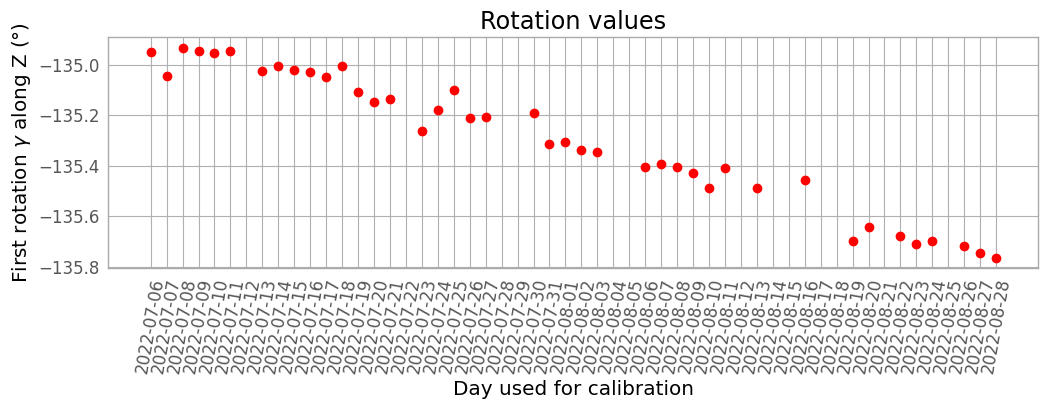

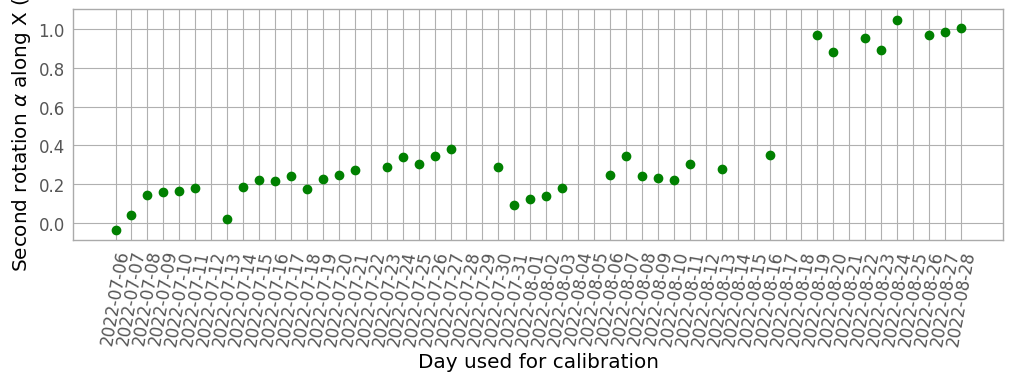

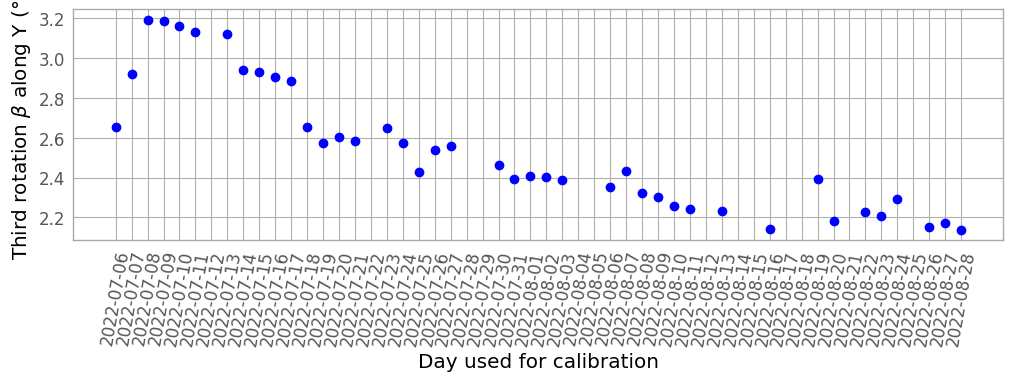

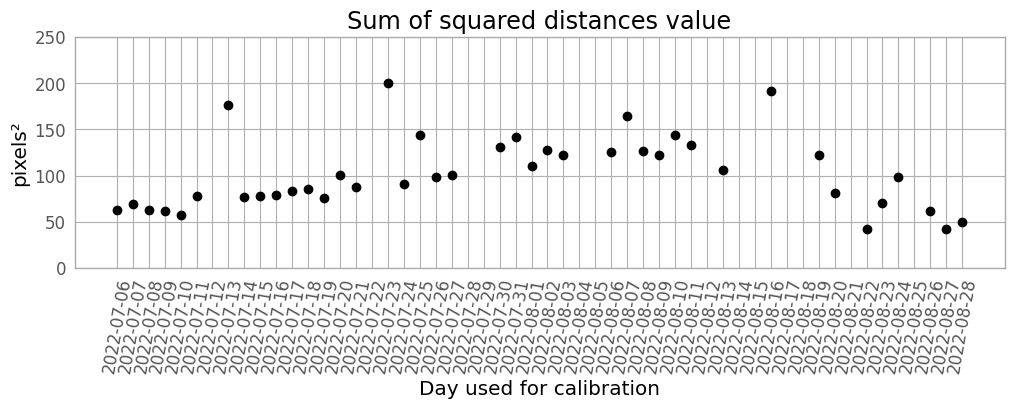

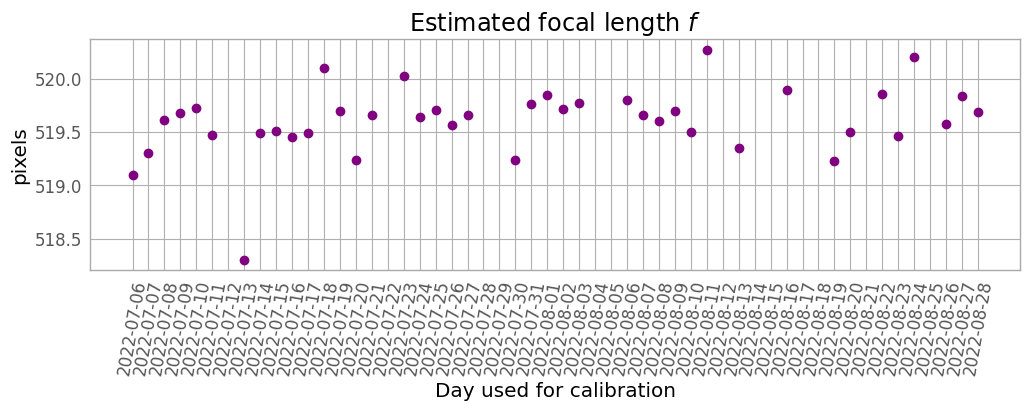

In [25]:
from datetime import datetime
for i in range(liste_resultats.shape[0]):
    xstring = "Day used for calibration"
    if liste_resultats[i, 2] < 200:
        date = liste_resultats[i,0]
        plt.figure(0, figsize=(12, 3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 1][0], c='r')
        plt.title("Rotation values")
        plt.xlabel(xstring)
        plt.ylabel(r"First rotation $\gamma$ along Z (°)")
        plt.xticks(liste_resultats[:,0], rotation=80)

        plt.figure(1, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 1][1], c='g')
        plt.xlabel(xstring)
        plt.ylabel(r"Second rotation $\alpha$ along X (°)")
        plt.xticks(liste_resultats[:,0], rotation=80)

        plt.figure(2, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 1][2], c='b')
        plt.xlabel(xstring)
        plt.ylabel(r"Third rotation $\beta$ along Y (°)")
        plt.xticks(liste_resultats[:,0], rotation=80)

        plt.figure(3, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 2], c='k')
        plt.title("Sum of squared distances value")
        plt.ylabel("pixels²")
        plt.xlabel(xstring)
        plt.ylim(0, 250)
        plt.xticks(liste_resultats[:,0], rotation=80)

        plt.figure(4, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 3], c='purple')
        plt.title(r"Estimated focal length $f$")
        plt.xlabel(xstring)
        plt.ylabel("pixels")
        plt.xticks(liste_resultats[:,0], rotation=80)

#plt.figure(0)
#plt.savefig("fig_drift0.png")
#plt.figure(1)
#plt.savefig("fig_drift1.png")
#plt.figure(2)
#plt.savefig("fig_drift2.png")
#plt.figure(3)
#plt.savefig("fig_drift3.png")
#plt.figure(4)
#plt.savefig("fig_drift4.png")


In [26]:
print(liste_resultats[6,0])

2022-07-12


## French version

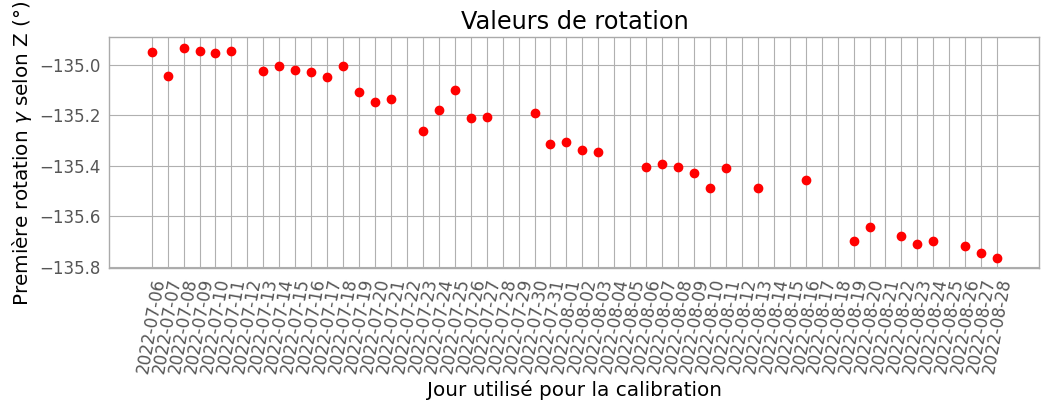

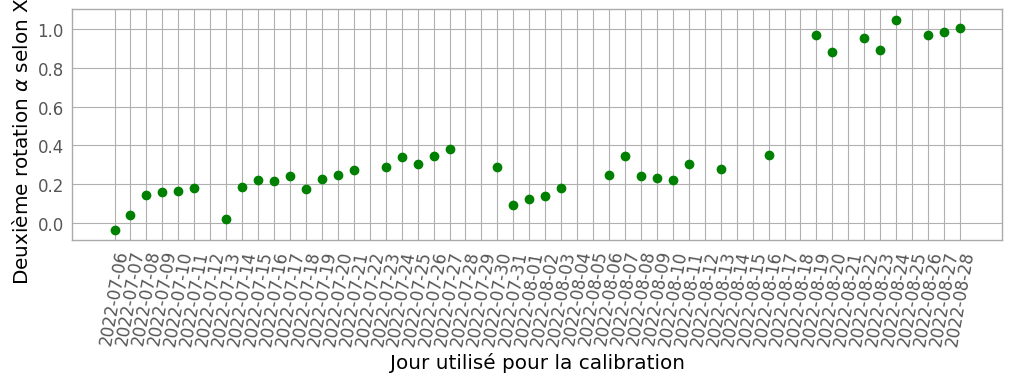

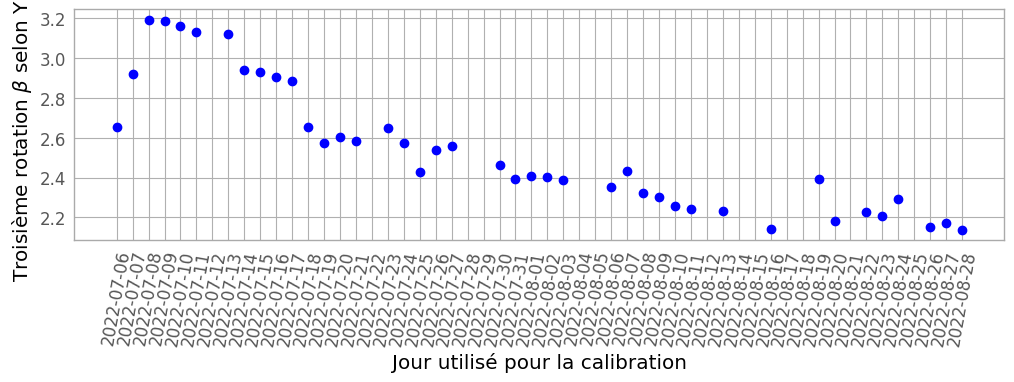

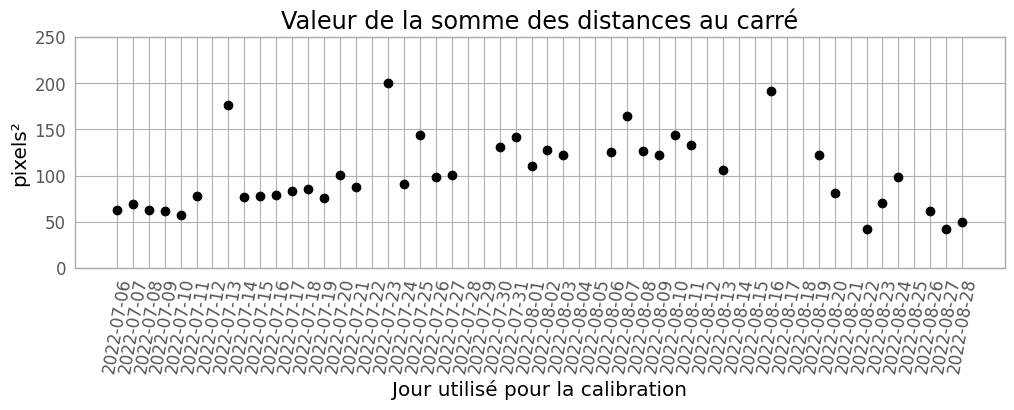

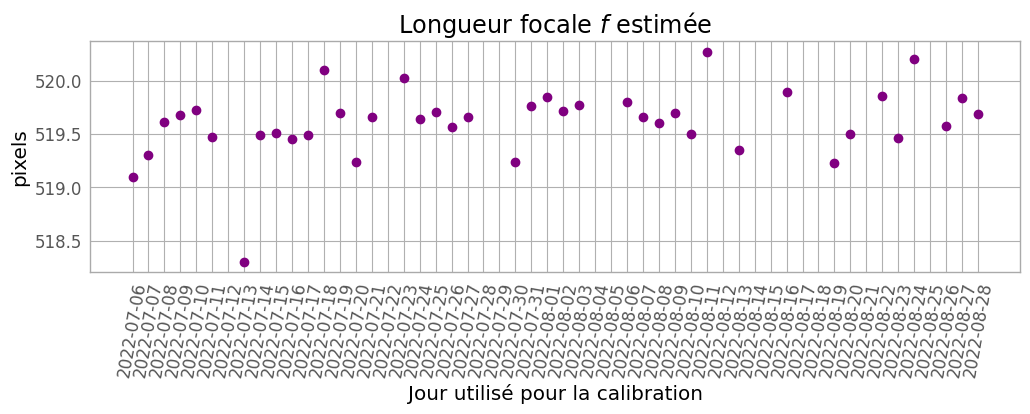

In [27]:
from datetime import datetime
for i in range(liste_resultats.shape[0]):
    xstring = "Jour utilisé pour la calibration"
    if liste_resultats[i, 2] < 200:
        date=liste_resultats[i,0]
        plt.figure(0, figsize=(12, 3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 1][0], c='r')
        plt.title("Valeurs de rotation")
        plt.xlabel(xstring)
        plt.ylabel(r"Première rotation $\gamma$ selon Z (°)")
        plt.xticks(liste_resultats[:,0], rotation=80)

        plt.figure(1, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 1][1], c='g')
        plt.xlabel(xstring)
        plt.ylabel(r"Deuxième rotation $\alpha$ selon X (°)")
        plt.xticks(liste_resultats[:,0], rotation=80)

        
        plt.figure(2, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 1][2], c='b')
        plt.xlabel(xstring)
        plt.ylabel(r"Troisième rotation $\beta$ selon Y (°)")
        plt.xticks(liste_resultats[:,0], rotation=80)

        
        plt.figure(3, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 2],c='k')
        plt.title("Valeur de la somme des distances au carré")
        plt.ylabel("pixels²")
        plt.xlabel(xstring)
        plt.ylim(0, 250)
        plt.xticks(liste_resultats[:,0], rotation=80)

        
        plt.figure(4, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 3], c='purple')
        plt.title(r"Longueur focale $f$ estimée")
        plt.xlabel(xstring)
        plt.ylabel("pixels")
        plt.xticks(liste_resultats[:,0], rotation=80)

#plt.figure(0)
#plt.savefig("fig_drift0.png")
#plt.figure(1)
#plt.savefig("fig_drift1.png")
#plt.figure(2)
#plt.savefig("fig_drift2.png")
#plt.figure(3)
#plt.savefig("fig_drift3.png")
#plt.figure(4)
#plt.savefig("fig_drift4.png")

In [28]:
liste_resultats_c[np.where(liste_resultats_c[:, 2] < 200), 3][0]

array([519.2282332863051, 519.2914969232345, 519.6032127966146,
       519.6740797303975, 519.7131338541336, 519.4676148835661,
       518.3189468585842, 519.4968291986836, 519.5035912158211,
       519.4581277938798, 519.4819109231538, 520.0939923491624,
       519.5570350223769, 519.2478864796734, 519.6584672080915,
       518.095046652859, 520.0192235781273, 519.6344069022269,
       519.6987785834898, 519.5489389471867, 519.6694755948898,
       519.232292717779, 519.6374486062949, 519.8476675814211,
       518.9985887796963, 519.7664893285696, 519.7781182065182,
       519.6366777910123, 519.5948660441999, 519.6921096197494,
       519.4659865882278, 518.883858120231, 519.8782538685887,
       519.2245175812521, 520.2809464532355, 519.7759370918025,
       519.4301834725, 520.0318088184381, 519.631848057911,
       519.9263442001832, 519.5972053095878], dtype=object)

# Plot Z,X,Y rotation values estimated for different days, with time drift correction

In [29]:
#Estimation of mean angular values and focal length over days with "good enough" fit
[Z_m,X_m,Y_m]=np.mean(np.vstack(np.array((liste_resultats_c[np.where(liste_resultats_c[:, 2] < 200), 1][0]))),axis=0)
f_m=np.mean(np.vstack(np.array((liste_resultats_c[np.where(liste_resultats_c[:, 2] < 200), 3][0]))))

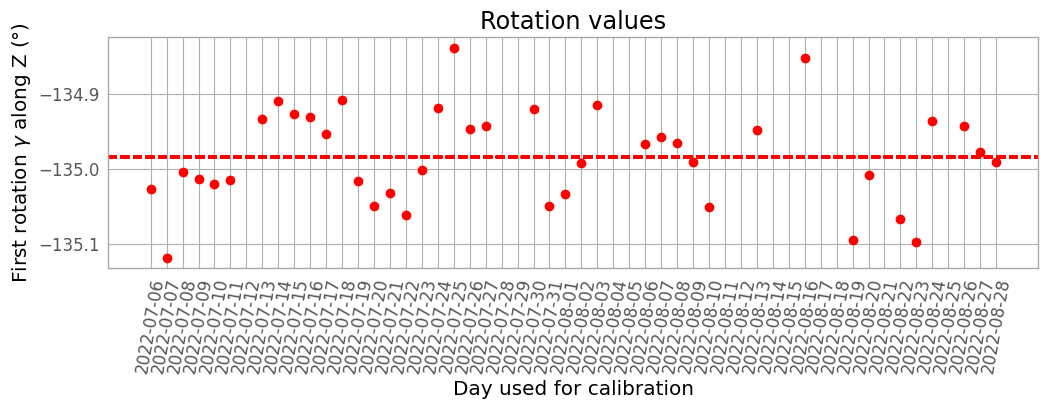

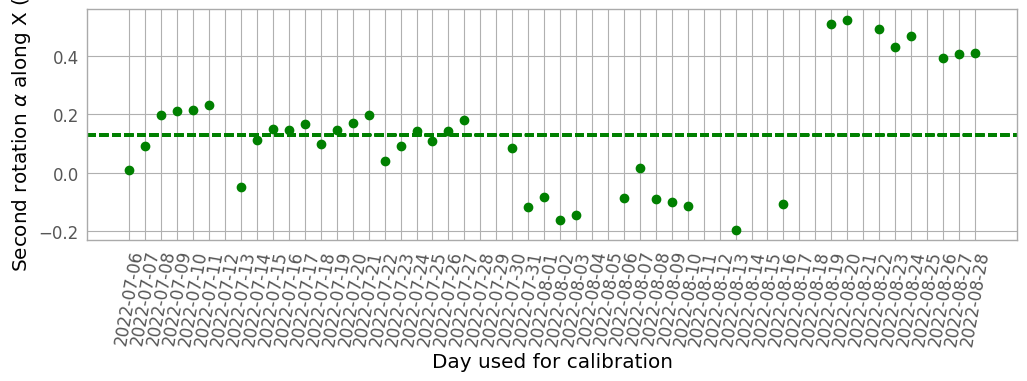

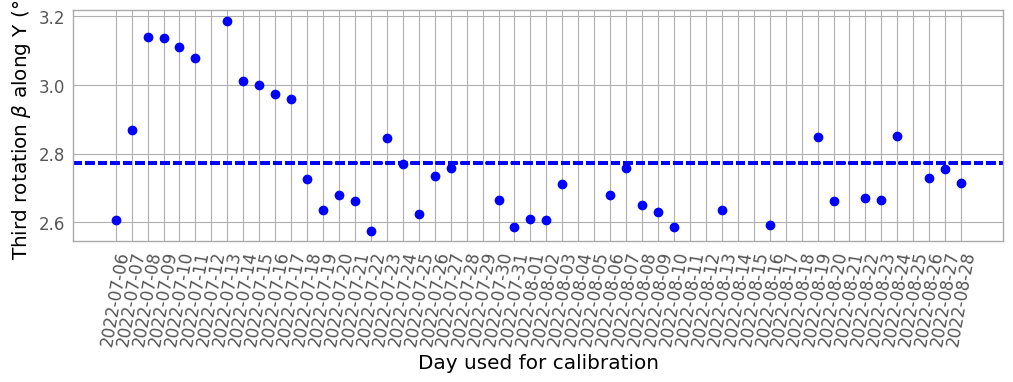

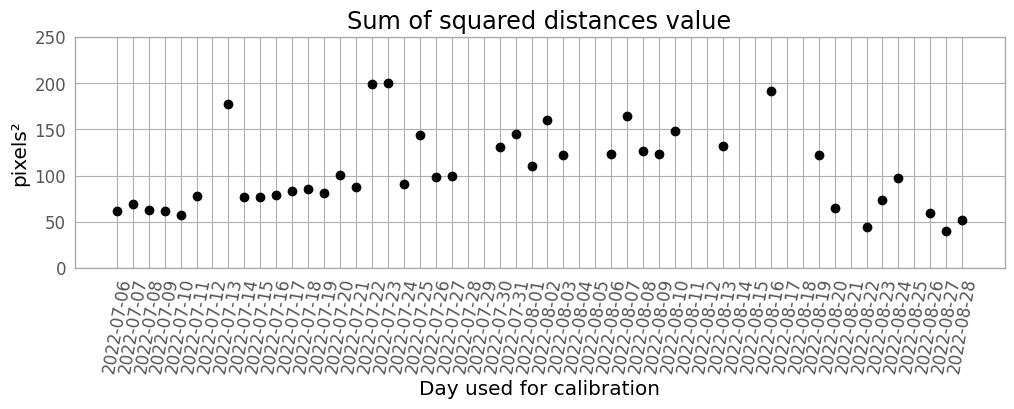

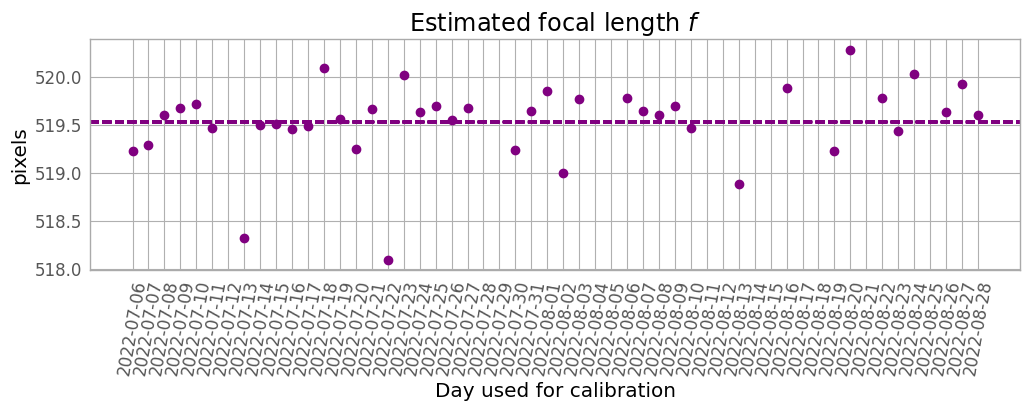

In [30]:
from datetime import datetime
for i in range(liste_resultats_c.shape[0]):
    xstring = "Day used for calibration"
    if liste_resultats_c[i, 2] < 200:
        date = liste_resultats_c[i, 0]
        plt.figure(0, figsize=(12, 3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats_c[i, 1][0], c='r')
        plt.title("Rotation values")
        plt.xlabel(xstring)
        plt.ylabel(r"First rotation $\gamma$ along Z (°)")
        plt.xticks(liste_resultats_c[:, 0], rotation=80)
        plt.axhline(y=Z_m, linestyle='--', color='r')  # Add mean line

        plt.figure(1, figsize=(12, 3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats_c[i, 1][1], c='g')
        plt.xlabel(xstring)
        plt.ylabel(r"Second rotation $\alpha$ along X (°)")
        plt.xticks(liste_resultats_c[:, 0], rotation=80)
        plt.axhline(y=X_m, linestyle='--', color='g')  # Add mean line

        plt.figure(2, figsize=(12, 3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats_c[i, 1][2], c='b')
        plt.xlabel(xstring)
        plt.ylabel(r"Third rotation $\beta$ along Y (°)")
        plt.xticks(liste_resultats_c[:, 0], rotation=80)
        plt.axhline(y=Y_m, linestyle='--', color='b')  # Add mean line

        plt.figure(3, figsize=(12, 3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats_c[i, 2], c='k')
        plt.title("Sum of squared distances value")
        plt.ylabel("pixels²")
        plt.xlabel(xstring)
        plt.ylim(0, 250)
        plt.xticks(liste_resultats_c[:, 0], rotation=80)

        plt.figure(4, figsize=(12, 3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats_c[i, 3], c='purple')
        plt.title(r"Estimated focal length $f$")
        plt.xlabel(xstring)
        plt.ylabel("pixels")
        plt.xticks(liste_resultats_c[:, 0], rotation=80)
        plt.axhline(y=f_m, linestyle='--', color='purple')  # Add mean line

#plt.figure(0)
#plt.savefig("fig_drift0.png")
#plt.figure(1)
#plt.savefig("fig_drift1.png")
#plt.figure(2)
#plt.savefig("fig_drift2.png")
#plt.figure(3)
#plt.savefig("fig_drift3.png")
#plt.figure(4)
#plt.savefig("fig_drift4.png")


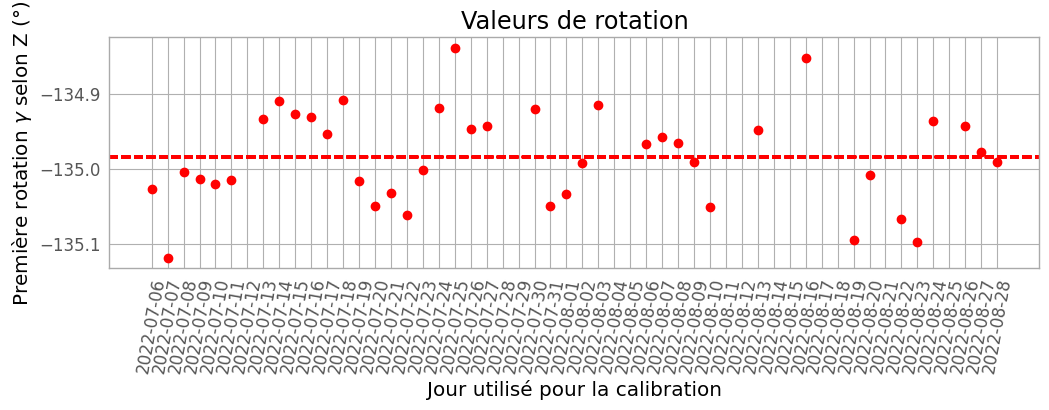

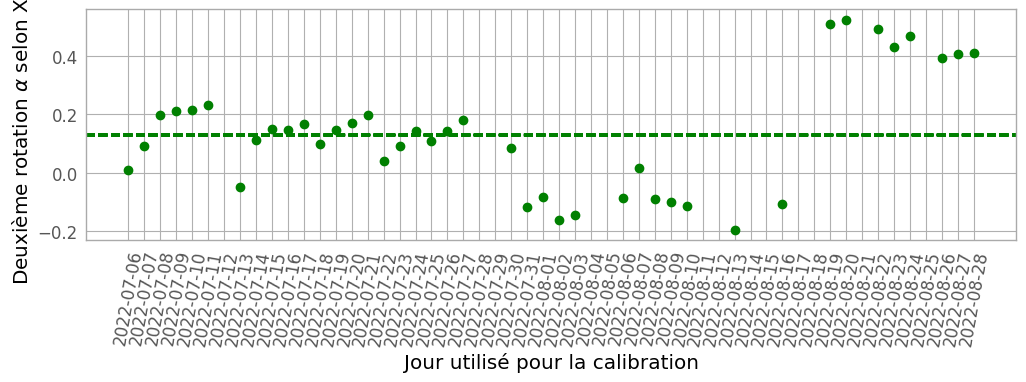

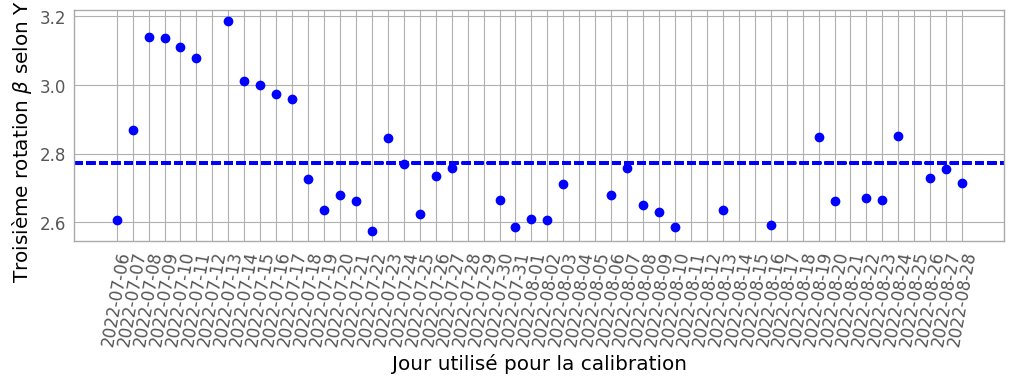

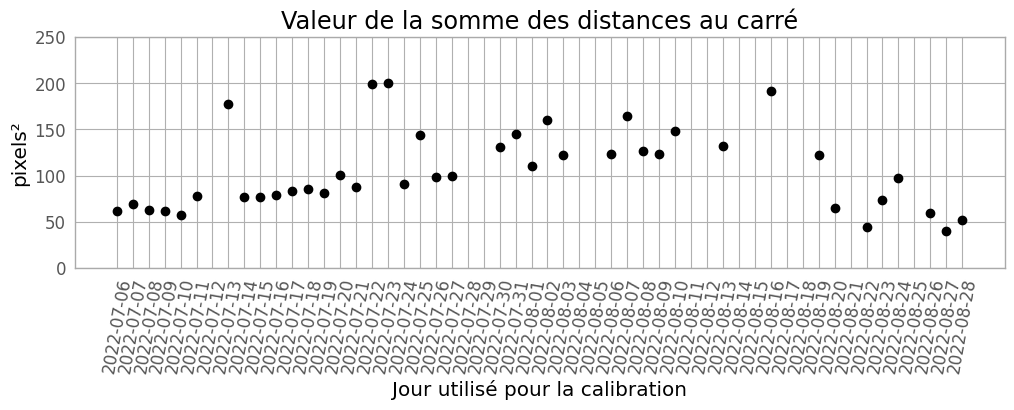

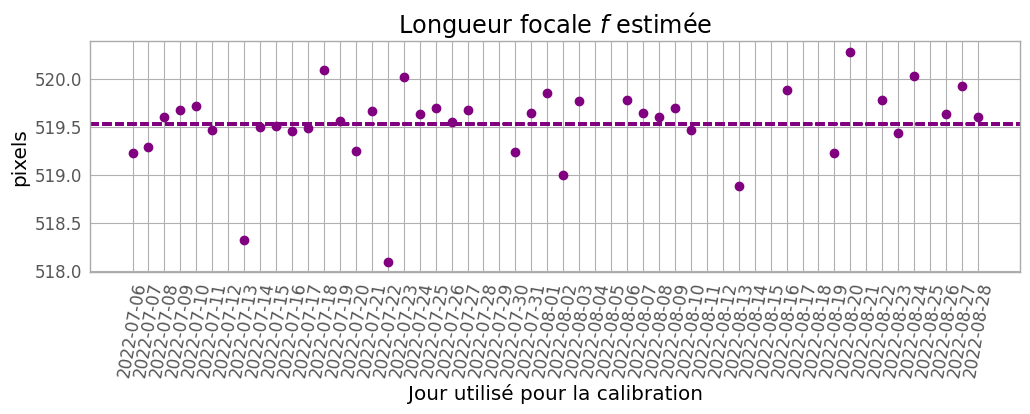

In [31]:
#French version
from datetime import datetime
for i in range(liste_resultats_c.shape[0]):
    xstring = "Jour utilisé pour la calibration"
    if liste_resultats_c[i, 2] < 200:
        date=liste_resultats_c[i,0]
        plt.figure(0, figsize=(12, 3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats_c[i, 1][0], c='r')
        plt.title("Valeurs de rotation")
        plt.xlabel(xstring)
        plt.ylabel(r"Première rotation $\gamma$ selon Z (°)")
        plt.xticks(liste_resultats_c[:,0], rotation=80)
        plt.axhline(y=Z_m, linestyle='--', color='r')  # Add mean line

        plt.figure(1, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats_c[i, 1][1], c='g')
        plt.xlabel(xstring)
        plt.ylabel(r"Deuxième rotation $\alpha$ selon X (°)")
        plt.xticks(liste_resultats_c[:,0], rotation=80)
        plt.axhline(y=X_m, linestyle='--', color='g')  # Add mean line

        
        plt.figure(2, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats_c[i, 1][2], c='b')
        plt.xlabel(xstring)
        plt.ylabel(r"Troisième rotation $\beta$ selon Y (°)")
        plt.xticks(liste_resultats_c[:,0], rotation=80)
        plt.axhline(y=Y_m, linestyle='--', color='b')  # Add mean line

        
        plt.figure(3, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats_c[i, 2],c='k')
        plt.title("Valeur de la somme des distances au carré")
        plt.ylabel("pixels²")
        plt.xlabel(xstring)
        plt.ylim(0, 250)
        plt.xticks(liste_resultats_c[:,0], rotation=80)

        
        plt.figure(4, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats_c[i, 3], c='purple')
        plt.title(r"Longueur focale $f$ estimée")
        plt.xlabel(xstring)
        plt.ylabel("pixels")
        plt.xticks(liste_resultats_c[:,0], rotation=80)
        plt.axhline(y=f_m, linestyle='--', color='purple')  # Add mean line
        

#plt.figure(0)
#plt.savefig("fig_drift0.png")
#plt.figure(1)
#plt.savefig("fig_drift1.png")
#plt.figure(2)
#plt.savefig("fig_drift2.png")
#plt.figure(3)
#plt.savefig("fig_drift3.png")
#plt.figure(4)
#plt.savefig("fig_drift4.png")

### Visualization of resulting errors in estimation of sun positions on sensor with chosen rotation and ephemerids VS detected centroids

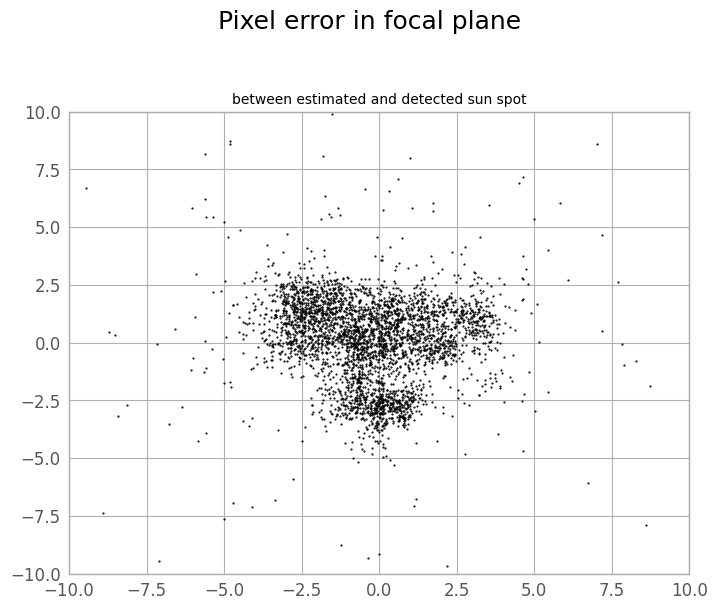

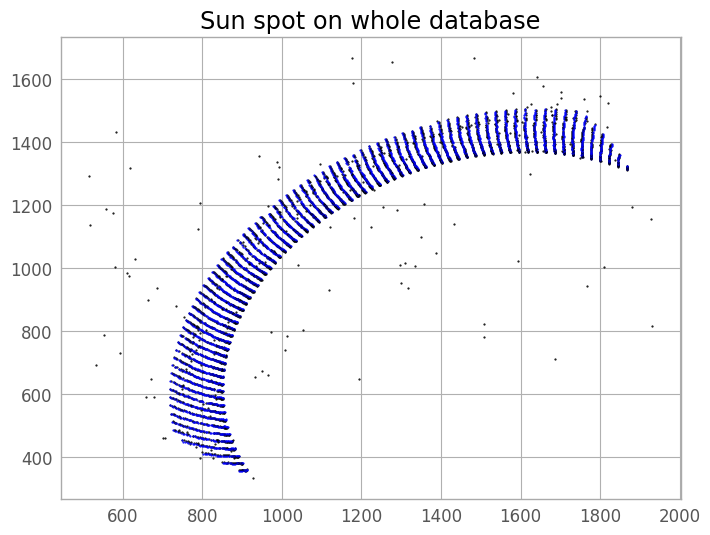

In [38]:
plt.figure(0)
plt.suptitle("Pixel error in focal plane",y=1.05, fontsize=18)
plt.title("between estimated and detected sun spot", fontsize=10)

plt.figure(1)
plt.title("Sun spot on whole database")

for jour in range(54):
    #print(jour)
    for i in range(len(liste_resultats_c[jour,6])):
        x_0,y_0=dist_center[0],dist_center[1]
        #print(liste_resultats_c[0,4][i]) 
        PTe=np.array([eph.getAltAzSoleil(liste_resultats_c[jour,6][i])])*np.pi/180
        #print(np.array([(Psi_sun,Theta_sun)]))
        centroides=np.array([liste_resultats_c[jour,4][i]])
        #print((centroides))
        PT=calcul_Psi_Theta_Mes(centroides,x_0,y_0,f_m)
        r = R.from_euler('ZXY',[Z_m,X_m,Y_m],degrees=True)
        PT_rot_cart=r.apply(np.array(sph2cart2(PT[:,0],PT[:,1])).T).T
        PT_rot=np.array(cart2sph2(PT_rot_cart[0,:],PT_rot_cart[1,:],PT_rot_cart[2,:])).T
        PTe_rep_cam_cart=r.inv().apply(np.array(sph2cart2(PTe[:,0],PTe[:,1])).T).T
        PTe_rep_cam=np.array(cart2sph2(PTe_rep_cam_cart[0,:],PTe_rep_cam_cart[1,:],PTe_rep_cam_cart[2,:])).T
        centroides_eph=np.column_stack((np.sin(PTe_rep_cam[:,0])*f_m*PTe_rep_cam[:,1]+x_0,np.cos(PTe_rep_cam[:,0])*f_m*PTe_rep_cam[:,1]+y_0))
        #print(centroides_eph)
        #print(np.array(centroides)-np.array(centroides_eph))
        plt.figure(0)
        plt.xlim(-10,10)
        plt.ylim(-10,10)
        plt.scatter((np.array(centroides)-np.array(centroides_eph))[0,0],(np.array(centroides)-np.array(centroides_eph))[0,1],s=0.3,c='k')
        plt.figure(1)
        plt.scatter((np.array(centroides))[0,0],(np.array(centroides))[0,1],c='k',s=0.3)
        plt.scatter((np.array(centroides_eph))[0,0],(np.array(centroides_eph))[0,1],c='b',s=0.3) 
        

## Do a linear fit on Z estimated values to see the effectiveness of time drift compensation on Z drift over days

Optimized parameters:
Slope (a): -0.01613095420935833
Intercept (b): -134.89354487660165


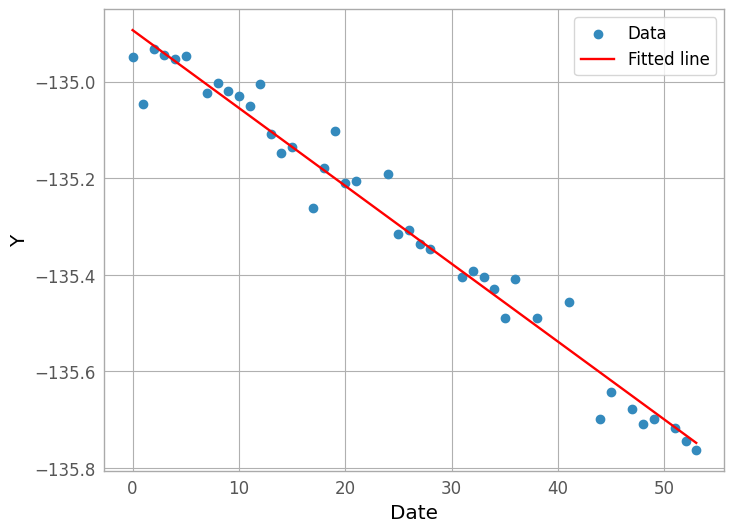

In [40]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Sample data with datetime x values
x_data = []#np.array([start_date + timedelta(days=i) for i in range(5)])
y_data = []#np.array([0.1, 0.9, 2.2, 2.8, 4.1])

for i in range(liste_resultats.shape[0]):
    if liste_resultats[i, 2] < 200:
        x_data.append(liste_resultats[i,0])
        y_data.append(liste_resultats[i, 1][0])

start_date = datetime.strptime(x_data[0], '%Y-%m-%d') #datetime(2024, 1, 1)


x_data_datetime = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in x_data]

# Now you can perform the subtraction
x_numeric = np.array([(date - start_date).days for date in x_data_datetime])

# Define a linear function
def linear_func(x, a, b):
    return a * x + b

# Fit the model to the data
popt, pcov = curve_fit(linear_func, x_numeric, y_data)

# Extract the optimized parameters
a_opt, b_opt = popt

print("Optimized parameters:")
print("Slope (a):", a_opt)
print("Intercept (b):", b_opt)

# Plot the data and the fitted line
plt.scatter(x_numeric, y_data, label='Data')
plt.plot(x_numeric, linear_func(x_numeric, *popt), color='red', label='Fitted line')
plt.xlabel('Date')
plt.ylabel('Y')
plt.legend()
plt.show()


Optimized parameters:
Slope (a): -1.4402791270740067e-05
Intercept (b): -134.98328031360856


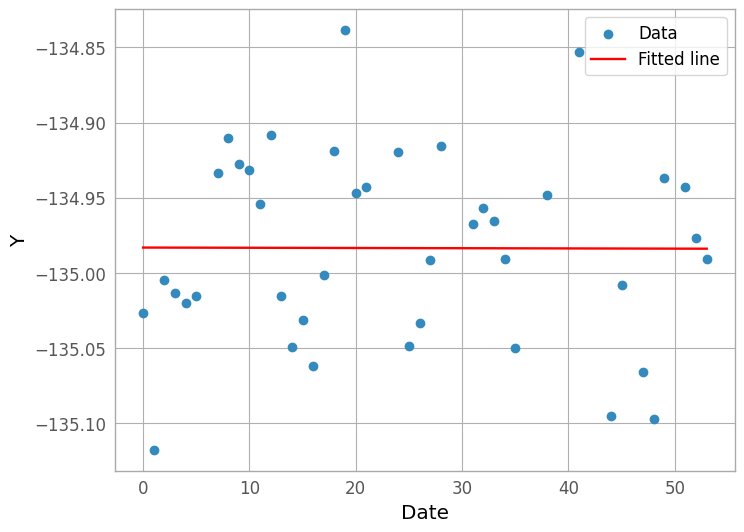

In [41]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Sample data with datetime x values
x_data = []#np.array([start_date + timedelta(days=i) for i in range(5)])
y_data = []#np.array([0.1, 0.9, 2.2, 2.8, 4.1])

for i in range(liste_resultats_c.shape[0]):
    if liste_resultats_c[i, 2] < 200:
        x_data.append(liste_resultats_c[i,0])
        y_data.append(liste_resultats_c[i, 1][0])


start_date = datetime.strptime(x_data[0], '%Y-%m-%d') #datetime(2024, 1, 1)
 
x_data_datetime = [datetime.strptime(date_str, '%Y-%m-%d') for date_str in x_data]

# Now you can perform the subtraction
x_numeric = np.array([(date - start_date).days for date in x_data_datetime])

# Define a linear function
def linear_func(x, a, b):
    return a * x + b

# Fit the model to the data
popt, pcov = curve_fit(linear_func, x_numeric, y_data)

# Extract the optimized parameters
a_opt, b_opt = popt

print("Optimized parameters:")
print("Slope (a):", a_opt)
print("Intercept (b):", b_opt)

# Plot the data and the fitted line
plt.scatter(x_numeric, y_data, label='Data')
plt.plot(x_numeric, linear_func(x_numeric, *popt), color='red', label='Fitted line')
plt.xlabel('Date')
plt.ylabel('Y')
plt.legend()
plt.show()


### Save values

In [44]:
print("Save params !")
print(calib_path)
shape_image=(1024*2,1224*2)

coords_image=[]
for i in range(shape_image[0]):
    for j in range(shape_image[1]):
        coords_image.append([j,i])
coords_image=np.array(coords_image)


orientation_pixels=calcul_Psi_Theta_Mes(coords_image,x_0,y_0,f_m)
r = R.from_euler('ZXY',[Z_m,X_m,Y_m],degrees=True)
OP_rot_cart=r.apply(np.array(sph2cart2(orientation_pixels[:,0],orientation_pixels[:,1])).T).T
OP_rot=np.array(cart2sph2(OP_rot_cart[0,:],OP_rot_cart[1,:],OP_rot_cart[2,:])).T
orientation_pixels_ENU=OP_rot.reshape((shape_image[0],shape_image[1],2))

np.save(calib_path+'rotation.npy',r.as_euler('ZXY',degrees=True))
np.save(calib_path+'rot_mat.npy',r.as_matrix())
np.save(calib_path+'orientation_pixels_ENU.npy',orientation_pixels_ENU)
np.save(calib_path+'f.npy',np.array(f_m))
np.save(calib_path+'dist_center.npy',np.array(dist_center))
lat=43.286990365824785
lon=5.403361407820939
np.save(calib_path+"lat_lon.npy",np.array([lat,lon]))
print("Saved !")

Save params !
/scratch/lpoughon/PolarizedDatabaseM/calib/
Saved !


### Plot results

In [45]:
def plot_results(centroides,centroides_eph,language='Fr'):
    '''
    Language can be 'Fr' or 'En'
    '''
    if language=='Fr':
        plt.figure()
        plt.title("Centroides détectés et course du soleil simulée pour la rotation estimée")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides[i,0],centroides[i,1],marker='+',color="k")#,label="Points Centroides")
            plt.scatter(centroides_eph[i,0],centroides_eph[i,1],marker='x',color="b")#,label="Points Centroides")
            #plt.scatter(centroides_ephm1[i,0],centroides_ephm1[i,1],marker='x',color="g")#,label="Points Centroides")

        plt.scatter(x_0,y_0,color="r",marker='o',label="Centre Optique")
        legend_elements = [plt.Line2D([0], [0], marker='+', color='k', label='Points de calibration mesures',markerfacecolor='k', markersize=5),
         plt.Line2D([0], [0], marker='x', color='b', label='Ephemeride par modele inverse',markerfacecolor='b', markersize=10),
         plt.Line2D([0], [0], marker='o', color='r', label='Centre Optique',markerfacecolor='r', markersize=10)]
        plt.legend(handles=legend_elements,handlelength=0)
        plt.xlabel("Pixels X")
        plt.ylabel("Pixels Y")

        plt.figure()
        plt.title("Erreur résiduelle")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides[i,0]-centroides_eph[i,0],centroides[i,1]-centroides_eph[i,1],marker='.',color="b")#,label="Points Centroides")
            #plt.scatter(centroides[i,0]-centroides_ephm1[i,0],centroides[i,1]-centroides_ephm1[i,1],marker='.',color="g")#,label="Points Centroides")

            #plt.scatter(,marker='.',color="b")#,label="Points Centroides")
        #plt.scatter(x_0,y_0,color="r",marker='o',label="Centre Optique")
        legend_elements = [plt.Line2D([0], [0], marker='.', color='b', label='Difference entre position detectée et éphémérides',markerfacecolor='k', markersize=1)]
        plt.legend(handles=legend_elements,handlelength=0)
        plt.xlabel("Pixels X")
        plt.ylabel("Pixels Y")
    
    else :        
        plt.figure()
        plt.title("Detected centroids and simulated sun course on sensor")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides_eph[i,0],centroides_eph[i,1],marker='x',color="b")#,label="Points Centroides")
            plt.scatter(centroides[i,0],centroides[i,1],marker='+',color="k")#,label="Points Centroides")
        plt.scatter(x_0,y_0,color="r",marker='o',label="Centre Optique")
        legend_elements = [plt.Line2D([0], [0], marker='x', color='b', label='Simulated sun course with estimated orientation', markerfacecolor='b', markersize=10), 
                           plt.Line2D([0], [0], marker='+', color='k', label='Measured calibration points', markerfacecolor='k', markersize=10), 
                           plt.Line2D([0], [0], marker='o', color='w', label='Camera optical center', markerfacecolor='r', markersize=10)]
        #legend_elements = [plt.Line2D([0], [0], marker='x', color='w', label='Simulated sun\'s course',markerfacecolor='b', markersize=15),plt.Line2D([0], [0], marker='+', color='w', label='Measured calibration points',markerfacecolor='k', markersize=15),plt.Line2D([0], [0], marker='.', color='w', label='Camera\'s optical center',markerfacecolor='r', markersize=15)]
        plt.legend(handles=legend_elements)
        plt.xlabel("X pixels")
        plt.ylabel("Y pixels")

        plt.figure()
        plt.title("Residual error")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides[i,0]-centroides_eph[i,0],centroides[i,1]-centroides_eph[i,1],marker='.',color="k")#,label="Points Centroides")

        plt.xlabel("X pixels")
        plt.ylabel("Y pixels")

In [46]:
def plot_eph_mes(Psi_Theta_eph,Psi_Theta_mes):
    """
    Cette fonction sert à afficher les deux ensembles de points correspondant aux positions successives du soleil, sous format "azimut - elevation" en radians (elevation nulle -> axe z), d'une part de l'ephemeride et d'autre part des orientations reconstruites.
    """

    Psi_Theta_eph=(np.array(Psi_Theta_eph)%(2*np.pi))
    Psi_Theta_mes=np.array(Psi_Theta_mes)%(2*np.pi)

    plt.figure(figsize=(12,12))

    ax3=plt.subplot(111, projection='polar', facecolor='#d5de9c')
    ax3.set_title("Orientations in ENU frame, spherical coordinates")

    plt.rc('grid', color='#316931', linewidth=1, linestyle='-')
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    ax3.set_theta_direction(-1)
    ax3.set_theta_zero_location('N')
    
    
    ax3.plot((Psi_Theta_mes[:,0]),np.degrees(Psi_Theta_mes[:,1]), color='k', lw=1,linestyle='None',marker='+', label='Mesured Sun orientation after inverse rotation')#(Psi_Theta_mes[:,0]-np.pi*0.75)
    ax3.plot(Psi_Theta_eph[:,0],np.degrees(Psi_Theta_eph[:,1]), color='b', lw=1,linestyle='None',marker='x', label='Ephemerids in ENU frame')

    ax3.legend()
    plt.figure()
    plt.title("Orientations in ENU frame, spherical coordinates")
    plt.plot(np.degrees(Psi_Theta_eph[:,1]),'rx',label='Zenith Angle of Ephemerids in ENU frame')
    plt.plot(np.degrees(Psi_Theta_eph[:,0]),'gx',label='Azimut of Ephemerids in ENU frame')
    plt.plot(np.degrees(Psi_Theta_mes[:,1]),'r+',label='Zenith Angle Mesured Sun orientation after inverse rotation')
    plt.plot(np.degrees(Psi_Theta_mes[:,0]),'g+',label='Azimut of Mesured Sun orientation after inverse rotation')
    plt.ylabel('Degrees')
    plt.xlabel('Images over the day')
    plt.legend()

### Use the best date for saving parameters

In [ ]:
PT=calcul_Psi_Theta_Mes(centroides,x_0,y_0,f) 
PT_rot_cart=r.apply(np.array(sph2cart2(PT[:,0],PT[:,1])).T).T
PT_rot=np.array(cart2sph2(PT_rot_cart[0,:],PT_rot_cart[1,:],PT_rot_cart[2,:])).T
plot_results(centroides,centroides_eph,language='Fr')

plot_eph_mes(PTe,PT_rot)

### Show sun detection stability in an animation in order to check any wrong detection

In [ ]:
def show_centroides_date(centroides_det,choosen_date,show=False): #detect centroids on images and give corresponding ephemerids, on a given date
    centroides_det=centroides_det.astype('int32')
    centroides_imagettes=[]
    Psi_Theta_eph=[]
    init_somme_image=0
    n_centroides=0
    for i_image in trange(len(dirs_files)):
        for chemins_pos in [dirs_files[i_image]]:
            chemins=np.load(path+chemins_pos)
            i_eme_image=-1
            angles_az=[]
            for chemin in chemins:#chemins_angles_raw_names:
                i_eme_image+=1
                #skip all images but not the one with lower exposure
                if i_eme_image!=5:
                    continue
                if chemin.split('T')[0][-10:]!=choosen_date: #keep only the correct date
                    continue
                png_raw_name=path+chemin.split('ManipeResultats/')[1]
                #print(png_raw_name)
                (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chemin.split('ManipeResultats/')[1])
                if 90-Theta_sun<10:continue #If the sun is too low on horizon
                image=np.load(png_raw_name+str(i_eme_image)+'.npy').astype('int64')
                if init_somme_image==0:
                    init_somme_image=1
                    somme_image=image.copy()
                else:
                    somme_image=somme_image+image
                taille_imagette=50
                centroides_imagettes.append(image[centroides_det[n_centroides][1]-taille_imagette:centroides_det[n_centroides][1]+taille_imagette,centroides_det[n_centroides][0]-taille_imagette:centroides_det[n_centroides][0]+taille_imagette])
                
                if show:
                    plt.figure()
                    plt.imshow( centroides_imagettes[n_centroides])
                n_centroides+=1
    return centroides_imagettes

In [ ]:
centroides.shape

In [ ]:
imagettes=show_centroides_date(centroides,choosen_date)

In [ ]:
#process_image(chemin,7)
video = np.array(imagettes)

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML



fig = plt.figure()
im = plt.imshow(video[0])


plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0])

def animate(i):
    im.set_data(video[i])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
display(HTML(anim.to_jshtml()))